#**Importing Necessary Modules and the Dataset and Setting Up Functions**


##*Necessary Modules*

In [ ]:
from sklearn.datasets import load_diabetes as db
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from typing import Type, Optional, Dict, Any, Union
import json

##*Useful Constants*

In [ ]:
RANDOM_SEED = 0
LINE_SEPARATOR = "\n" + "-" * 200 + "\n"

##*Useful Functions*

###*Viewing and evaluating outputs functions*

In [ ]:
# Function to evaluate and calculate r2 (linear regression / Hold-Out)
def evaluate(y_train: np.ndarray, y_pred_train: np.ndarray, y_test: np.ndarray, y_pred_test: np.ndarray) -> tuple[float, float, float]:
    """
    Evaluate the performance of a linear regression model with Hold-Out.

    Parameters:
    - y_train (np.ndarray): True values for the training set.
    - y_pred_train (np.ndarray): Predicted values for the training set.
    - y_test (np.ndarray): True values for the test set.
    - y_pred_test (np.ndarray): Predicted values for the test set.

    Returns:
    - r2_train (float): R^2 score for the training set.
    - r2_test (float): R^2 score for the test set.
    - gap_di_performance (float): Performance gap indicating overfitting or underfitting.
    """
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    gap_di_performance = 1 - (r2_test / r2_train)
    return r2_train, r2_test, gap_di_performance


# Function to evaluate and calculate r2 mean (linear regression + cross validation)
def evaluate_cv(train_scores: np.ndarray, test_scores: np.ndarray) -> tuple[float, float, float]:
    """
    Evaluate the performance of a linear regression model with cross-validation.

    Parameters:
    - train_scores (np.ndarray): Array of R^2 scores for the training set from cross-validation.
    - test_scores (np.ndarray): Array of R^2 scores for the test set from cross-validation.

    Returns:
    - mean_train_score (float): Mean R^2 score for the training set.
    - mean_test_score (float): Mean R^2 score for the test set.
    - gap_di_performance (float): Performance gap indicating overfitting or underfitting.
    """
    mean_train_score = train_scores.mean()
    mean_test_score = test_scores.mean()
    gap_di_performance = 1 - (mean_test_score / mean_train_score)

    return mean_train_score, mean_test_score, gap_di_performance


# Dictionary to store evaluation results
evaluation_dict: Dict[str, Dict[str, Union[float, str]]] = {}

# Function to add results to the evaluation dictionary
def add_to_evaluation_dict(title: str, train_score: float, test_score: float, gap_di_performance: float, degree: Optional[int] = None) -> None:
    """
    Add evaluation results to the evaluation dictionary.

    Parameters:
    - title (str): Title for the evaluation entry.
    - train_score (float): R^2 score for the training set.
    - test_score (float): R^2 score for the test set.
    - gap_di_performance (float): Performance gap indicating overfitting or underfitting.
    - degree (Optional[int]): Degree of the polynomial if applicable.

    Returns:
    - None
    """
    if degree is not None:
        title = f"{title} degree {degree}"
    if title not in evaluation_dict:
        evaluation_dict[title] = {}
    evaluation_dict[title]["Train"] = train_score
    evaluation_dict[title]["Test"] = test_score
    evaluation_dict[title]["Gap di performance"] = gap_di_performance


# Function to format numerical values to three decimal places
def format_dict(d: Dict[str, Any]) -> None:
    """
    Format numerical values in a dictionary to three decimal places.

    Parameters:
    - d (Dict[str, Any]): Dictionary containing the values to format.

    Returns:
    - None
    """
    for key, value in d.items():
        if isinstance(value, dict):
            format_dict(value)
        elif isinstance(value, (int, float)):
            d[key] = f"{value:.3f}"
        elif isinstance(value, str):
            try:
                num = float(value)
                d[key] = f"{num:.3f}"
            except ValueError:
                pass


# Function to graphically visualize results
def graphic_visualization(y_real: np.ndarray, y_pred: np.ndarray, evaluation: str = " ",
                          fig_x: int = 10, fig_y: int = 6, text_x: float = 0.7,
                          text_y: float = 0.05, text_fontsize: int = 9) -> None:

    sns.set_theme()
    plt.figure(figsize=(fig_x, fig_y))

    """
    Graphically visualize the results of a model's predictions.

    Parameters:
    - y_real (np.ndarray): Array of true values.
    - y_pred (np.ndarray): Array of predicted values.
    - evaluation (str): Evaluation text to display on the plot.
    - fig_x (int): Width of the figure.
    - fig_y (int): Height of the figure.
    - text_x (float): X-coordinate for the evaluation text placement.
    - text_y (float): Y-coordinate for the evaluation text placement.
    - text_fontsize (int): Font size for the evaluation text.

    Returns:
    - None
    """
    plt.scatter(y_real, y_pred, alpha=0.6)
    plt.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--')
    ax = plt.gca()
    plt.xlabel("Train_True Values")
    plt.ylabel("Predictions")
    plt.title("Train _ True Values vs Predictions")
    plt.text(x=text_x, y=text_y, s=evaluation, transform=ax.transAxes, fontsize= text_fontsize)

    plt.grid(True)
    plt.show()


def graphic_visualization_coefficients(model, X: pd.DataFrame, y: pd.Series, fig_x: int = 10, fig_y: int = 6, bar_width: float = 0.8) -> None:
    """
    Graphically visualize the coefficients of a regression model.

    Parameters:
    - model: The trained regression model.
    - X (pd.DataFrame): The feature matrix.
    - y (pd.Series): The target vector.
    - fig_x (int): Width of the figure.
    - fig_y (int): Height of the figure.
    - bar_width (float): Width of the bars.

    Returns:
    - None
    """
    # Set the Seaborn theme for better aesthetics (optional, for consistent style)
    sns.set_theme()

    # Extract coefficients from the model
    coefficients = model.coef_
    features = X.columns

    # Create the bar plot
    plt.figure(figsize=(fig_x, fig_y))
    bars = plt.bar(features, coefficients, width=bar_width)
    plt.title('Model Coefficients')
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
    plt.xticks(rotation=90)  # Rotate x labels for better readability if needed

    # Add the values at the top of the bars
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{bar.get_height():.2f}',
            ha='center',
            va='bottom' if bar.get_height() >= 0 else 'top',
            color='black', fontsize = 9
        )

    plt.show()


# Function to plot the learning curve
def print_learning_curve(model, X: np.ndarray, y: np.ndarray, random_state: Optional[int] = None) -> None:
    """
    Plot the learning curve of a model.

    Parameters:
    - model: The machine learning model.
    - X (np.ndarray): Feature matrix.
    - y (np.ndarray): Target vector.
    - random_state (Optional[int]): Random state for reproducibility.

    Returns:
    - None
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, random_state=random_state)

    plt.plot(train_sizes, train_scores.mean(axis=1), label="Training score")
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Test score")
    plt.grid(True)
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

###*Linear regression with Hold-Out functions*

In [ ]:
# Function to split and scale the data
def split_scaler_data(data: tuple[np.ndarray, np.ndarray], test_size: float, random_state: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split and scale the data.

    Parameters:
    - data (tuple[np.ndarray, np.ndarray]): Tuple containing the feature matrix X and target vector y.
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Scaled training and testing data.
    """
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test


# Function to test the model and display graphs
def evaluate_model_with_visualization(model: Any, data: tuple[np.ndarray, np.ndarray], test_size: float = 0.3, visualization: bool = False) -> tuple[str, str]:
    """
    Test the model and display graphs.

    Parameters:
    - model (Any): The machine learning model to evaluate.
    - data (tuple[np.ndarray, np.ndarray]): Tuple containing the feature matrix X and target vector y.
    - test_size (float): Proportion of the dataset to include in the test split.
    - visualization (bool): Whether to visualize the results.

    Returns:
    - tuple[str, str]: Evaluation strings for training and test sets.
    """
    # Split and scale the data
    X_train, X_test, y_train, y_test = split_scaler_data(data, test_size, RANDOM_SEED)

    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the training and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    r2_train, r2_test, performance_gap = evaluate(y_train, y_pred_train, y_test, y_pred_test)
    evaluation_train = f"Train R2 score: {r2_train:.3f}"
    evaluation_test = f"Test R2 score: {r2_test:.3f}\nPerformance gap: {performance_gap:.3f}"

    if visualization:
        # Visualize the predictions on the training data
        graphic_visualization(y_train, y_pred_train, evaluation_train)

        # Visualize the predictions on the test data
        graphic_visualization(y_test, y_pred_test, evaluation_test)

    return evaluation_train, evaluation_test

###*Linear regression with cross validation functions*

In [ ]:
# Function to perform cross-validation on the model
def cross_validate_model(model: Any, X: pd.DataFrame, y: pd.Series, k: int = 5) -> tuple[np.ndarray, np.ndarray, pd.Series, pd.Series, np.ndarray, np.ndarray]:
    """
    Perform cross-validation on the model.

    Parameters:
    - model (Any): The machine learning model to evaluate.
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target vector.
    - k (int): Number of folds for cross-validation.

    Returns:
    - tuple containing predictions and true values for training and test sets, and arrays of train and test scores.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)
    train_scores = []
    test_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        r2_train, r2_test, performance_gap = evaluate(y_train, y_pred_train, y_test, y_pred_test)

        train_scores.append(r2_train)
        test_scores.append(r2_test)

    return y_pred_train, y_pred_test, y_train, y_test, np.array(train_scores), np.array(test_scores)


# Function to evaluate the model with cross-validation and optionally visualize the results
def evaluate_model_with_visualization_cv(model: Any, data: tuple[pd.DataFrame, pd.Series], k: int = 5, visualization: bool = False) -> tuple[float, float, float]:
    """
    Evaluate the model with cross-validation and optionally visualize the results.

    Parameters:
    - model (Any): The machine learning model to evaluate.
    - data (tuple[pd.DataFrame, pd.Series]): Tuple containing the feature matrix X and target vector y.
    - k (int): Number of folds for cross-validation.
    - visualization (bool): Whether to visualize the results.

    Returns:
    - tuple containing mean train score, mean test score, and performance gap.
    """
    X, y = data
    y_pred_train, y_pred_test, y_train, y_test, train_scores, test_scores = cross_validate_model(model, X, y, k)

    mean_train_score, mean_test_score, performance_gap = evaluate_cv(train_scores, test_scores)

    evaluation_train = f"Mean Train R2 score: {mean_train_score:.3f}"
    evaluation_test = f"Mean Test R2 score: {mean_test_score:.3f}\nPerformance gap: {performance_gap:.3f}"

    print(evaluation_train)
    print(evaluation_test)

    if visualization:
        # Visualize the predictions on the training data
        graphic_visualization(y_train, y_pred_train, evaluation_train)

        # Visualize the predictions on the test data
        graphic_visualization(y_test, y_pred_test, evaluation_test)

    return mean_train_score, mean_test_score, performance_gap

###*Polynomial regression functions*


In [ ]:
# Function to evaluate a polynomial regression model
def evaluate_polynomial_model(data: tuple[pd.DataFrame, pd.Series], degree: int, bias: bool = False, visualization: bool = False) -> tuple[float, float, float]:
    """
    Evaluate a polynomial regression model.

    Parameters:
    - data (tuple[pd.DataFrame, pd.Series]): Tuple containing the feature matrix X and target vector y.
    - degree (int): Degree of the polynomial features.
    - bias (bool): Whether to include a bias (intercept) term.
    - visualization (bool): Whether to visualize the results.

    Returns:
    - tuple containing mean train score, mean test score, and performance gap.
    """
    X, y = data
    poly = PolynomialFeatures(degree=degree, include_bias=bias)
    X_poly = poly.fit_transform(X)

    # Convert X_poly to a Pandas DataFrame to use .iloc
    X_poly = pd.DataFrame(X_poly)

    return evaluate_model_with_visualization_cv(LinearRegression(), (X_poly, y), visualization=visualization)

###*Regularization functions*

In [ ]:
# Function to evaluate regularized models with cross-validation
def evaluate_regularized_model_cv(model_class: Type[Any], data: tuple[pd.DataFrame, pd.Series], alpha_values: list[float], k: int = 5, best_r2_train_non_reg: Optional[float] = None, best_r2_test_non_reg: Optional[float] = None, tolerance: float = 0.05) -> tuple[Any, Optional[float], Optional[float], Optional[float], Optional[float]]:
    """
    Evaluate regularized models with cross-validation.

    Parameters:
    - model_class (Type[Any]): The class of the model to evaluate.
    - data (tuple[pd.DataFrame, pd.Series]): Tuple containing the feature matrix X and target vector y.
    - alpha_values (list[float]): List of alpha values to evaluate.
    - k (int): Number of folds for cross-validation.
    - best_r2_train_non_reg (Optional[float]): Best R2 score on training data for non-regularized model.
    - best_r2_test_non_reg (Optional[float]): Best R2 score on test data for non-regularized model.
    - tolerance (float): Tolerance for performance comparison:
      The tolerance variable was entered as a useful parameter to identify the best imperparameters by identifying those that allow R^2 values
      to be maintained on both the train set and the test set high.

    Returns:
    - tuple containing the best model, best train R2 score, best test R2 score, best alpha, and best performance gap.
    """
    X, y = data

    best_model = None
    best_r2_train = None
    best_r2_test = None
    best_performance_gap = None

    for alpha in alpha_values:
        model = model_class(alpha=alpha)
        y_pred_train, y_pred_test, y_train, y_test, train_scores, test_scores = cross_validate_model(model, X, y, k)

        mean_train_score, mean_test_score, performance_gap = evaluate_cv(train_scores, test_scores)

        print(f"\nAlpha: {alpha}")
        print(f"Mean R2 train: {mean_train_score:.3f}")
        print(f"Mean R2 test: {mean_test_score:.3f}")
        print(f"Performance gap: {performance_gap:.3f}\n")

        # Check if the current model satisfies the conditions
        if (best_r2_train_non_reg is None or best_r2_test_non_reg is None or
            (mean_train_score >= best_r2_train_non_reg - tolerance and
             mean_test_score >= best_r2_test_non_reg - tolerance and
             (best_performance_gap is None or performance_gap < best_performance_gap))):

                best_model = model
                best_r2_train = mean_train_score
                best_r2_test = mean_test_score
                best_performance_gap = performance_gap

    return best_model, best_r2_train, best_r2_test, best_performance_gap


# Function to evaluate Elastic Net models with cross-validation
def evaluate_elastic_net_model(data: tuple[pd.DataFrame, pd.Series], alpha_values: list[float], l1_ratio_values: list[float], k: int = 5, best_r2_train_non_reg: Optional[float] = None, best_r2_test_non_reg: Optional[float] = None, tolerance: float = 1.0) -> tuple[Any, Optional[float], Optional[float], pd.DataFrame]:
    """
    Evaluate Elastic Net models with cross-validation.

    Parameters:
    - data (tuple[pd.DataFrame, pd.Series]): Tuple containing the feature matrix X and target vector y.
    - alpha_values (list[float]): List of alpha values to evaluate.
    - l1_ratio_values (list[float]): List of L1 ratio values to evaluate.
    - k (int): Number of folds for cross-validation.
    - best_r2_train_non_reg (Optional[float]): Best R2 score on training data for non-regularized model.
    - best_r2_test_non_reg (Optional[float]): Best R2 score on test data for non-regularized model.
    - tolerance (float): Tolerance for performance comparison.

    Returns:
    - tuple containing the best model, best train R2 score and best test R2 score
    """
    X, y = data

    best_model = None
    best_r2_train = None
    best_r2_test = None
    best_performance_gap = None

    for alpha in alpha_values:
        for l1_ratio in l1_ratio_values:
            # Create a new model with the specified alpha and l1_ratio values
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=RANDOM_SEED)

            # Train the model
            y_pred_train, y_pred_test, y_train, y_test, train_scores, test_scores = cross_validate_model(model, X, y, k)

            mean_train_score, mean_test_score, performance_gap = evaluate_cv(train_scores, test_scores)

            # Print the results
            print(f"\nAlpha: {alpha}, L1 Ratio: {l1_ratio}")
            print(f"Mean R2 train: {mean_train_score:.3f}")
            print(f"Mean R2 test: {mean_test_score:.3f}")
            print(f"Performance gap: {performance_gap:.3f}\n")

            # Check if the current model satisfies the conditions
            if (best_r2_train_non_reg is None or best_r2_test_non_reg is None or
                (mean_train_score >= best_r2_train_non_reg - tolerance and
                 mean_test_score >= best_r2_test_non_reg - tolerance and
                 (best_performance_gap is None or performance_gap < best_performance_gap))):

                    best_model = model
                    best_r2_train = mean_train_score
                    best_r2_test = mean_test_score
                    best_performance_gap = performance_gap

    return best_model, best_r2_train, best_r2_test, best_performance_gap

#**Explorative Analysis**

##*Preliminary analysis*

In [ ]:
print(db().DESCR)
print(LINE_SEPARATOR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

The database consists of 11 features that are all numerical; the last column 'target' represents precisely the target, that is, a quantitative measure of disease progress after one year.

Since there are numerical variables/features and numerical target, it can be inferred that it is a linear regression problem.

It can be further inferred that the data already have scaling (known as “Frobenius scaling”).

Since it is a regression problem it would be convenient to use StandardScaler scaling (mean = 0 and variance = 1) to make the features more interpretable and improve convergence.

It is not convenient to apply the scaling now, since we will also need to test the polynomial regression, in which case it would be better to apply the scaling after the creation of the polynomial features, to confirm what was hypothesized.

This is followed by further analysis of the dataset. Converting it to a pandas DataFrame for simplicity.


In [ ]:
# Load the data using db function
data = db(return_X_y= False, as_frame=True, scaled=False)
"""
With the argument return_X_y=False, I get the features and the target in a single dataset (with =True, vice versa),
with scaled=False, I get the data unscaled (with =True, I would get the Frobenius scaled data),
and with as_frame=True, I get a DataFrame (with =False, vice versa).
"""
df = pd.DataFrame(data.frame)
print(df.head())
print(LINE_SEPARATOR)

# Check data type and distribution
print(df.info())
print(LINE_SEPARATOR)
print(df.describe())
print(LINE_SEPARATOR)

    age  sex   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0  2.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0  1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0  2.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0  1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0  1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    flo

df.info() shows that there are no null values, so there is no need to perform missing value cleanup, and that all values are of type float64.

The database is small: 11 features for 442 observations.

With df.describe() information is obtained on quartiles, mean, minimum and maximum value, as well as the number of observations for each column.

The study of the correlations between the features and the target is then proceeded with, so as to have a clearer idea of the type of regression to be implemented, linear or polynomial.

##*Analysis of correlations between the variables with the target*

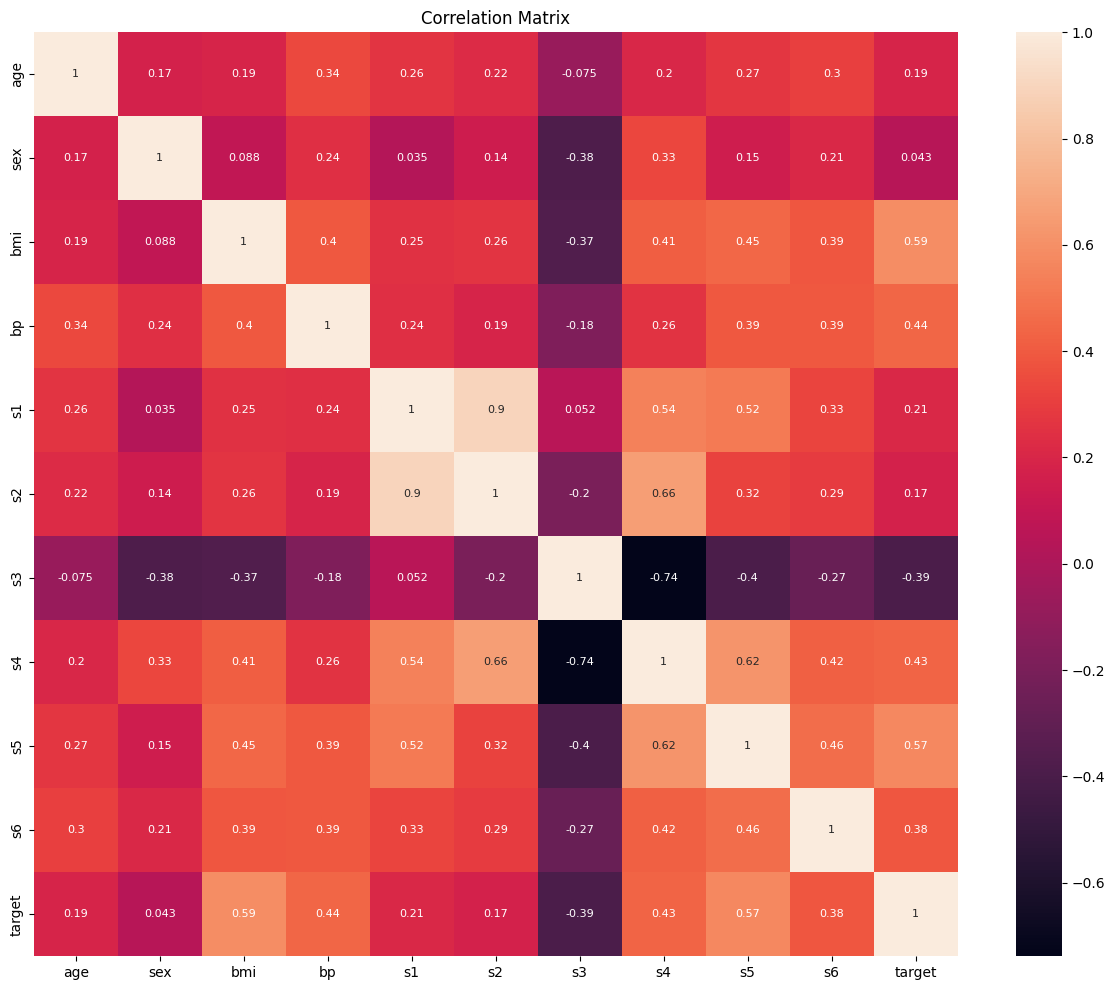


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Features with weak correlations (|r| < 0.25): ['age', 'sex', 's1', 's2']

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Features with moderate correlations (0.25 ≤ |r| < 0.5): ['bp', 's3', 's4', 's6']

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Features with strong correlations (|r| ≥ 0.5): ['bmi', 's5']


In [ ]:
# Visualize correlations between variables
correlation_matrix = df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix,
            cbar=True,
            square=True,
            annot=True,
            annot_kws={"size": 8})

plt.title('Correlation Matrix')
plt.show()

print(LINE_SEPARATOR)

# Classification of correlations
weak_corr = []
medium_corr = []
strong_corr = []

# Define correlation thresholds
weak_threshold = 0.25
medium_threshold = 0.5

for column in correlation_matrix.columns:
    if column != 'target':  # Exclude the target column from classification
        correlation = abs(correlation_matrix[column].values[-1])
        if correlation < weak_threshold:
            weak_corr.append(column)
        elif correlation < medium_threshold:
            medium_corr.append(column)
        else:
            strong_corr.append(column)

# Print classified features
print(f"Features with weak correlations (|r| < {weak_threshold}): {weak_corr}")
print(LINE_SEPARATOR)
print(f"Features with moderate correlations ({weak_threshold} ≤ |r| < {medium_threshold}): {medium_corr}")
print(LINE_SEPARATOR)
print(f"Features with strong correlations (|r| ≥ {medium_threshold}): {strong_corr}")

In the above code, it can first visualize the correlation matrix using a heatmap. This provides a visual representation of the correlation coefficients between the variables in the dataset.

Then, features based on their absolute correlation values with the target variable are categorized.  

The thresholds for weak, moderate, and strong correlations are defined as follows:
Weak correlation: |r| < {weak_threshold}
Moderate correlation: {weak_threshold} ≤ |r| < {medium_threshold}
Strong correlation: |r| ≥ {medium_threshold}

This classification helps to understand the strength of the relationships between the features and the target variable, which can be useful for feature selection and model building.

In general, it can be seen that the variables with strong correlation with the target are 'bmi' and 's5' . Important correlation also for the variables 'bp', 's3', 's4', 's6'. While the others have weak correlation, especially the feature 'sex' which is close to zero (consider that it is a discrete numerical variable).

It might be thought to estimate the model by considering all variables and then all variables minus those with weak relationship, especially the 'sex' feature.

Notice also a high collinearity between feature s3 and s4, lighter for other variables.

Meanwhile, it becomes useful to understand whether the relationships of individual features with the target are linear by setting up graphs and an initial linear regression.

In [ ]:
# Separate features (X) and target (y)
X = df.drop("target", axis=1)
y = df["target"]

# Print the shapes of X and y
print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (442, 10)
y shape = (442,)


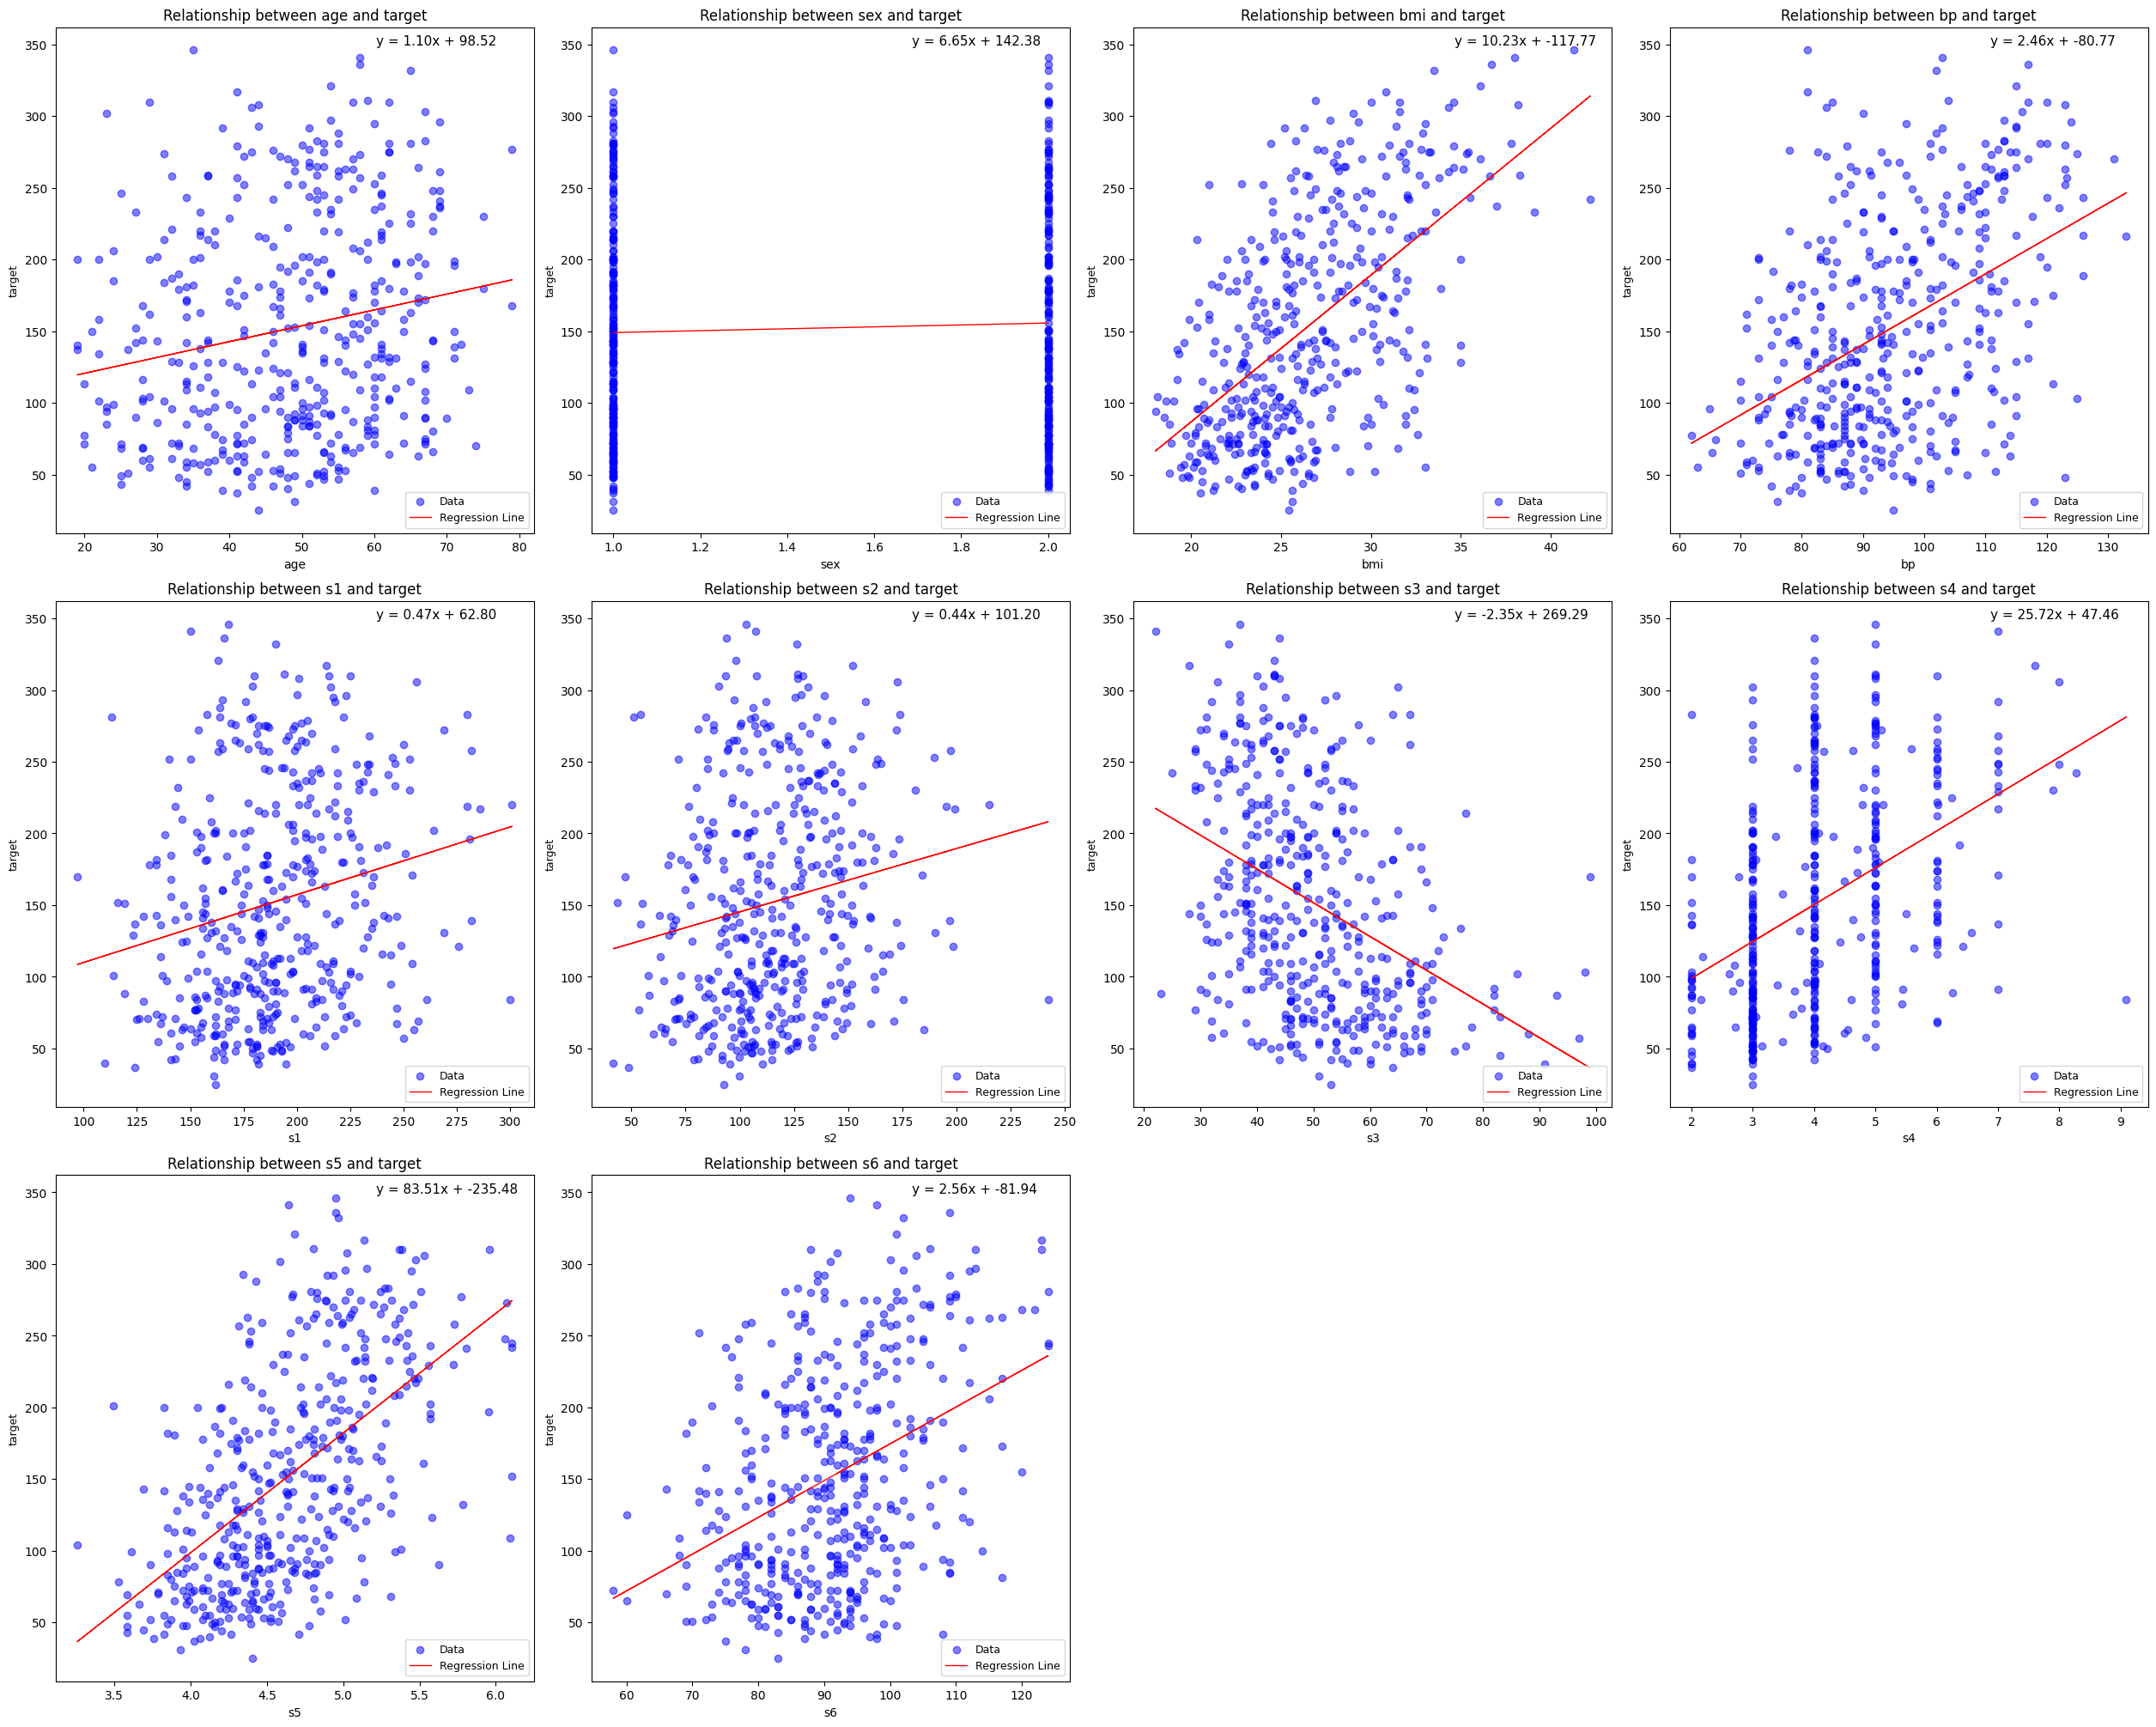

In [ ]:
# Define the number of columns and rows for subplots
num_columns = len(df.columns) # Total number of columns in the DataFrame
num_rows = 3  # Desired number of rows
cols_per_row = 4  # Number of columns per row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(25, 20), constrained_layout=True)
# constrained_layout=True ensures that subplots do not overlap and are arranged neatly
axes = axes.flatten()  # Flatten the array for easier access

# Visualize relationships between features and target
for i, column in enumerate(X):

    X_feature = X[column].values.reshape(-1, 1) # Reshape feature column to 2D array

    lr = LinearRegression()
    lr.fit(X_feature, y)
    y_pred = lr.predict(X_feature)

    m = lr.coef_[0]  # Regression coefficient (slope)
    b = lr.intercept_  # Intercept

    # Plot the scatter plot and regression line in the corresponding subplot
    axes[i].scatter(X_feature, y, color='blue', alpha=0.5, label='Data')
    axes[i].plot(X_feature, y_pred, color='red', linewidth=1, label='Regression Line')
    axes[i].set_title(f'Relationship between {column} and target')
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('target', fontsize=9)
    axes[i].text(x=0.67, y=0.965, s=f"y = {m:.2f}x + {b:.2f}", transform=axes[i].transAxes, fontsize=11)
    axes[i].legend(loc=4, fontsize=9)  # Place the legend in the lower right corner

# Remove empty axes (if the number of subplots is greater than the number of columns)
for j in range(i + 1, len(axes)):  # The first argument indicates the starting index of the loop, the second the end index
    fig.delaxes(axes[j])  # Delete axes

plt.show()

From the graphs obtained it can be seen that there is a linear relationship between the features and the target, this suggests opting for a multiple linear regression.

In addition, the slope of the line of the variable 'sex' indicates little significant impact on the target, as also shown by the correlation matrix.

The study continues with the analysis of the outliners, which can inform us more about the type of linear regression to be implemented and indicate possible regularization.

##*Outliners Analysis*

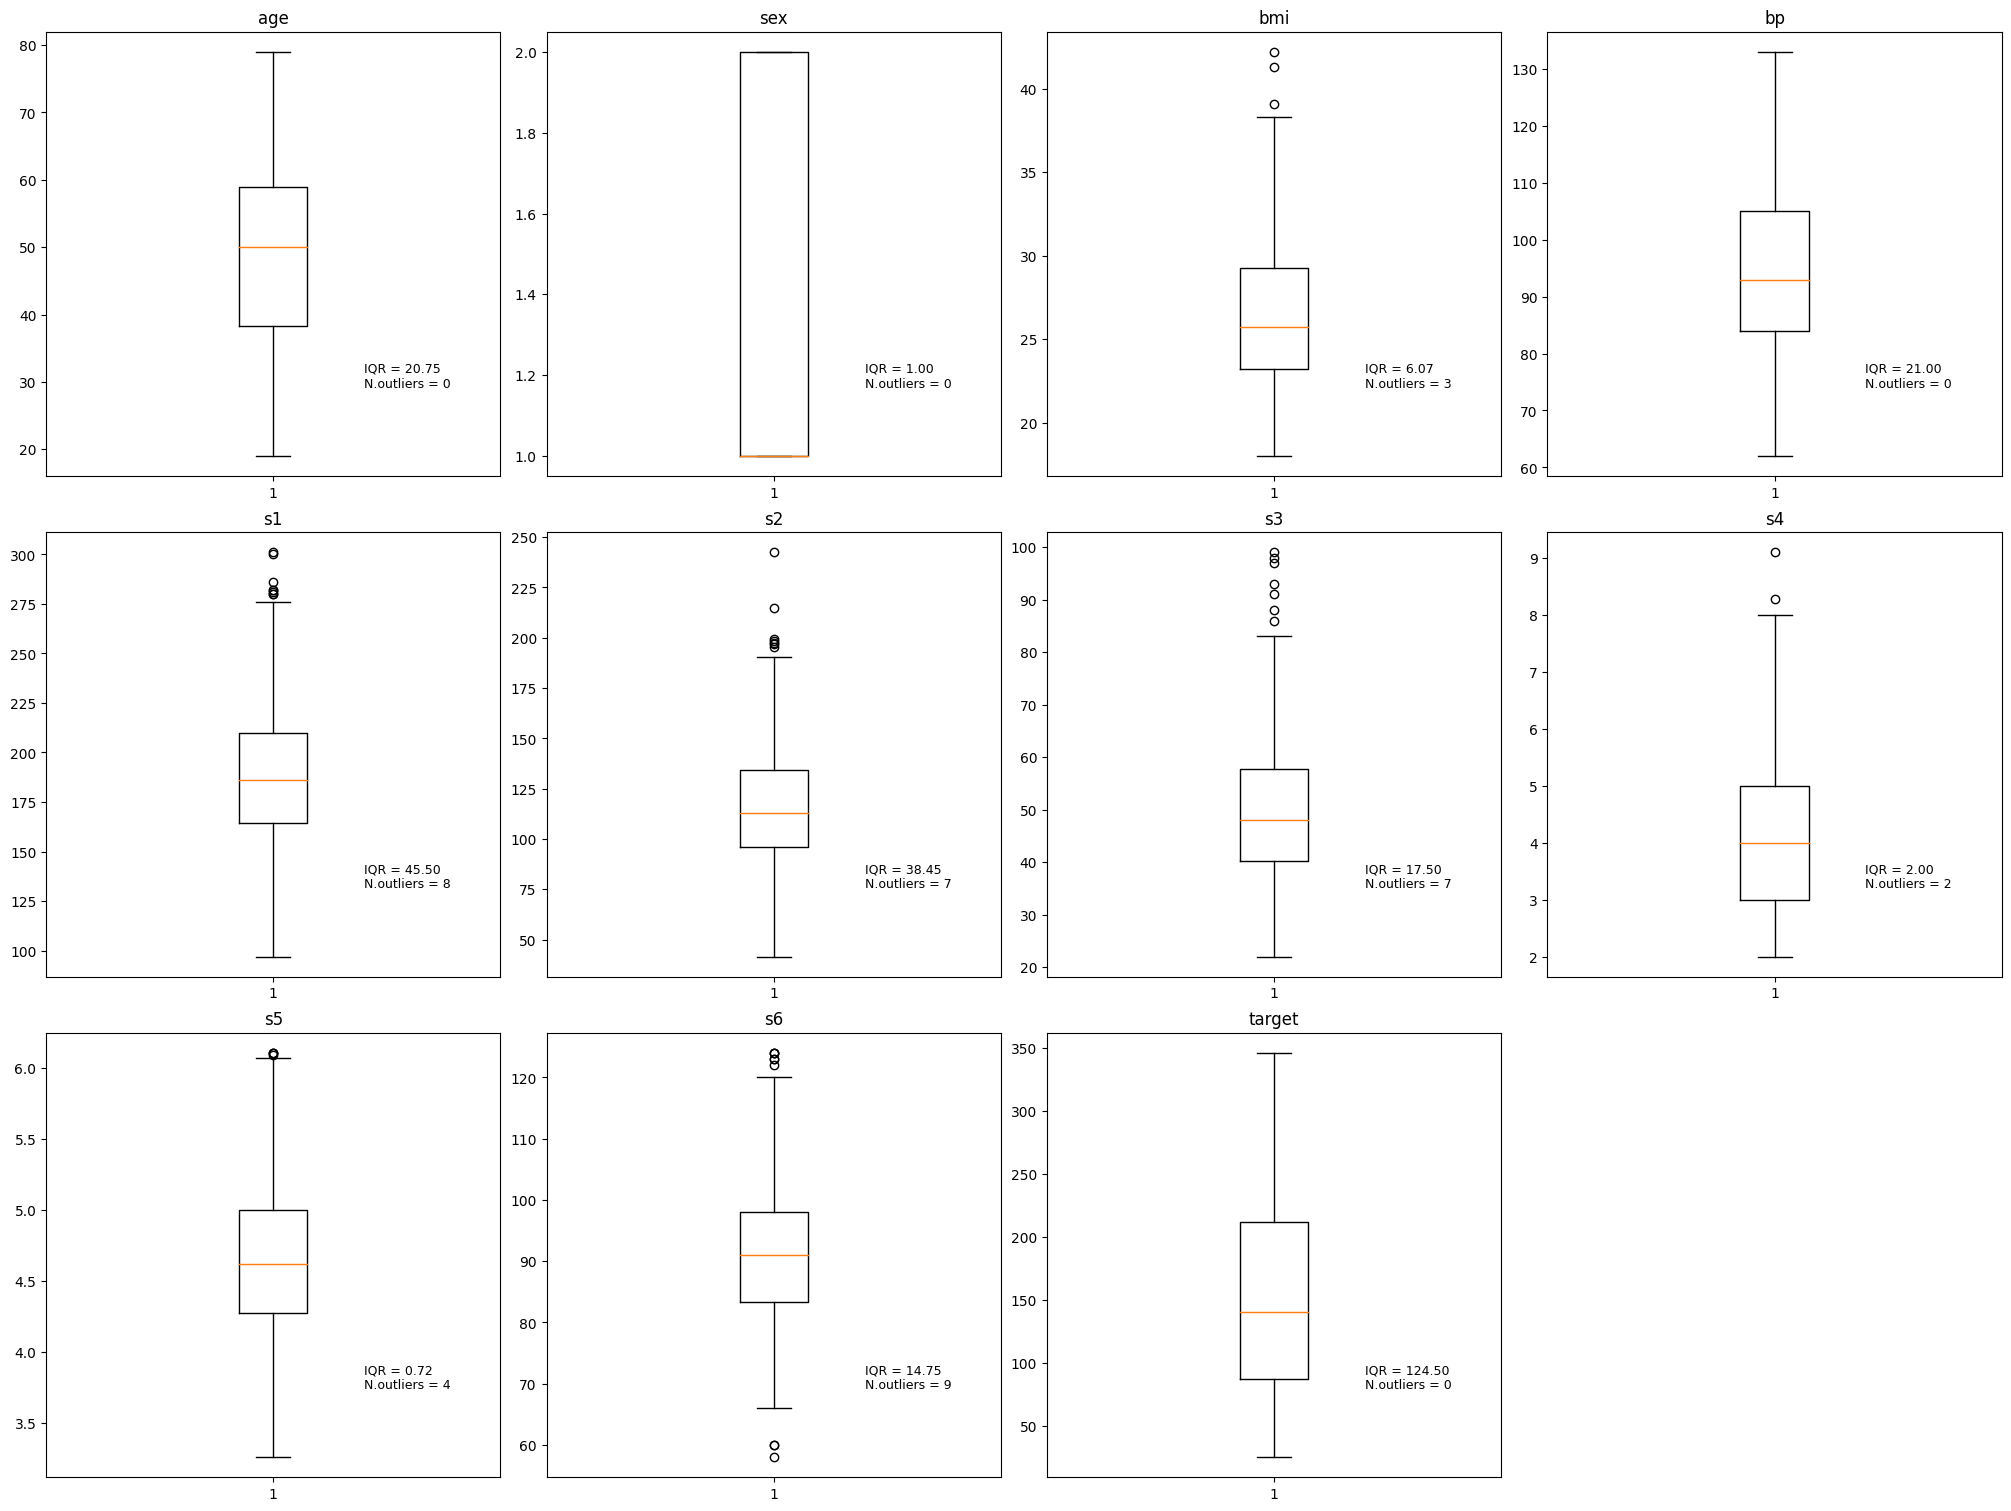


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

              age         sex         bmi          bp          s1          s2  \
count  411.000000  411.000000  411.000000  411.000000  411.000000  411.000000   
mean    48.508516    1.472019   26.238686   94.573358  186.136253  113.939903   
std     13.268955    0.499825    4.230209   13.545239   31.903298   28.215258   
min     19.000000    1.000000   18.000000   62.000000   97.000000   41.600000   
25%     39.000000    1.000000   23.200000   85.000000  163.000000   96.000000   
50%     50.000000    1.000000   25.700000   93.000000  185.000000  113.000000   
75%     59.000000    2.000000   29.000000  104.165000  206.000000  132.100000   
max     79.000000    2.000000   38.300000  133.000000  269.000000  190.200000   

               s3          s4          s5          s6      target  

In [ ]:
# Create a copy of the DataFrame to remove outliers from
df_no_outliers = df.copy()

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=cols_per_row, figsize=(20, 15), constrained_layout=True)
# constrained_layout=True ensures that subplots do not overlap and are arranged neatly
axes = axes.flatten()  # Flatten the array for easier access

# Iterate over each column in the DataFrame
for i, column in enumerate(df.columns):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile Range (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers
    outliers = [x for x in df[column] if x < lower_bound or x > upper_bound]  # Identify outliers

    # Remove outliers from the DataFrame copy
    df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]

    # Plot the boxplot in the corresponding subplot
    axes[i].boxplot(df[column].values)
    axes[i].set_title(df[column].name)
    axes[i].text(x=0.7, y=0.2, s=f"IQR = {IQR:.2f}\nN.outliers = {len(outliers)}", transform=axes[i].transAxes, fontsize=9)

# Remove empty axes (if the number of subplots is greater than the number of columns)
for j in range(i + 1, len(axes)):  # The first argument indicates the starting index of the loop, the second the end index
    fig.delaxes(axes[j])  # Delete axes

plt.show()

# Print a separator line
print(LINE_SEPARATOR)

# Display statistical summary of the DataFrame without outliers
print(df_no_outliers.describe())

###*Observations*

From the analysis of the IQR, it can be deduced that, in general, all features have fairly concentrated values and that 6 out of 10 features (excluding the target) have values that can be considered as 'outliners,' but in fairly small numbers.

In any case, a copy of the dataset cleaned of rows with outliners is created to train and evaluate the model on this as well.

It can be seen that from 442 observations we went to 411 observations, 31 fewer observations, despite the presence of 40 outliners, which means that for some observations there were several features with values that could be considered as outliners.

##*Final Observations (Explorative Analysis)*

The presence of outliners, although minimal, allows the possible use of L1 - Lasso regression to be considered, while the collinearity identified earlier suggests the use of L2 - Ridge regression.

The use of both via ElasticNet is also possible.

These options will be evaluated later.

#**Pre-processing and Model Training**

##*Data Pre-processing*

###*Analysis to identify the best subdivision of the dataset*

Evaluation with test size = 0.2


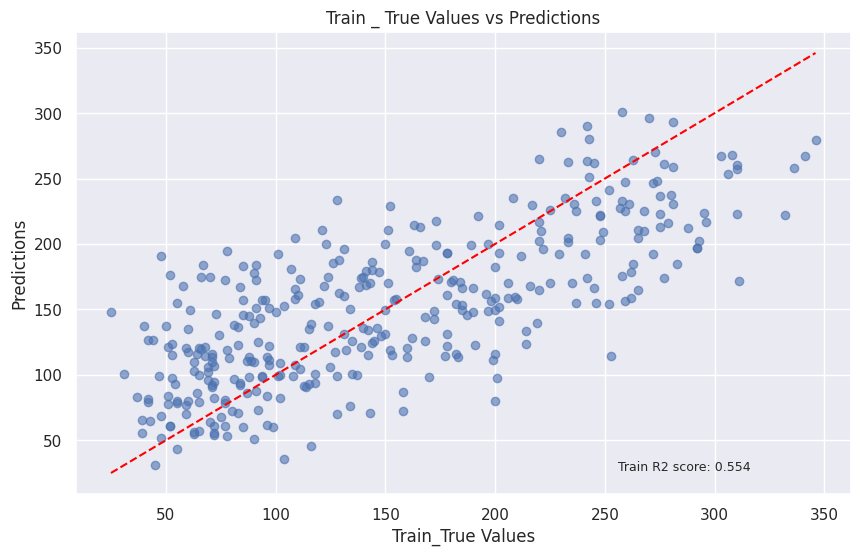

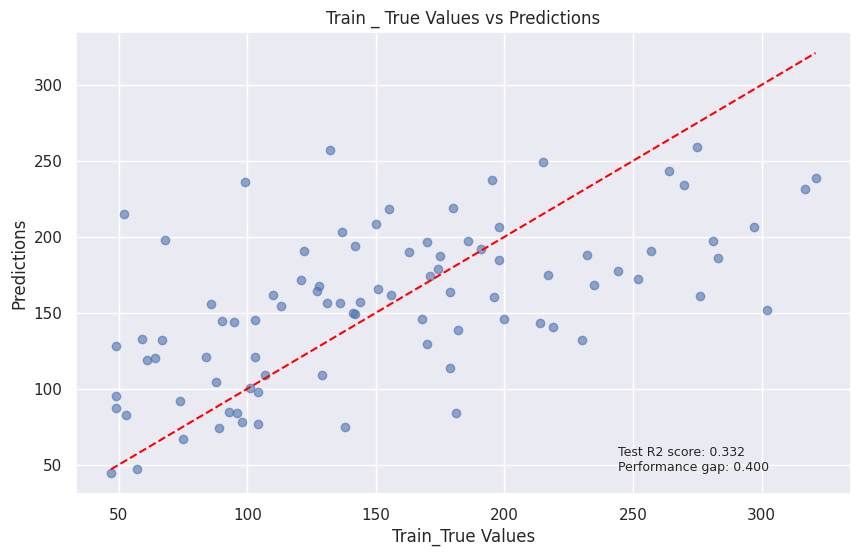


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Evaluation with test size = 0.3


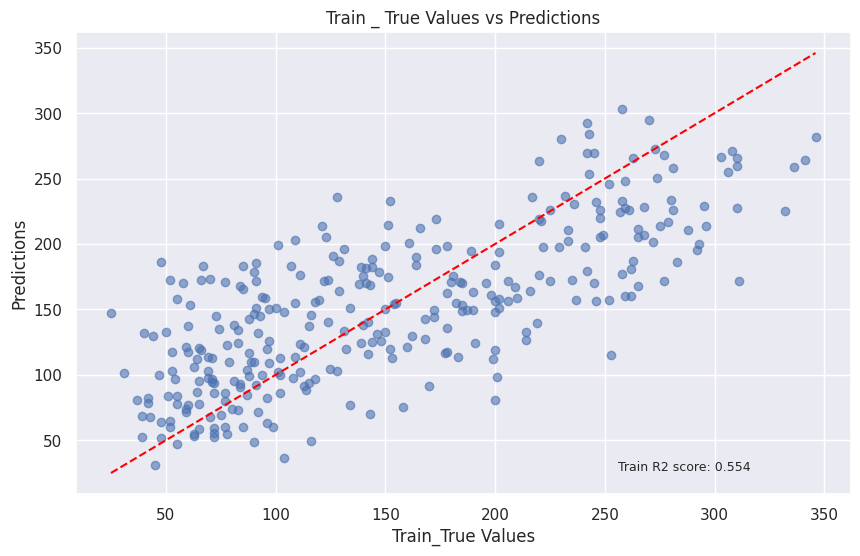

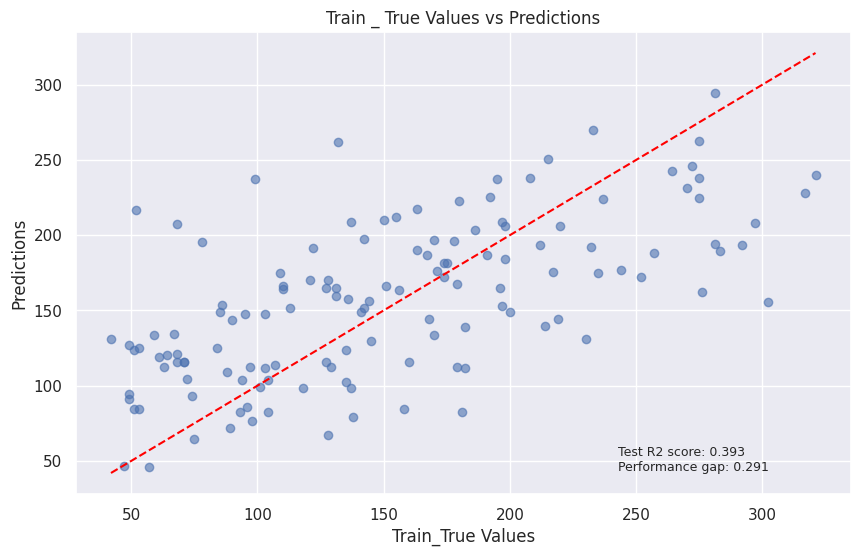


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
# Define different test sizes for evaluation
test_sizes = [0.2, 0.3]
for t_s in test_sizes:
    print(f"Evaluation with test size = {t_s}")
    evaluation_train, evaluation_test = evaluate_model_with_visualization(LinearRegression(), (X, y), t_s, visualization=True)
    print(LINE_SEPARATOR)

It can be seen that using a 30% test set (0.3) gives better performance in terms of model generalization ability, as indicated by the R2 value.

It is continued by testing, instead of Hold-Out, cross validation with different k-fold values between 5 and 10, the dataset being small in size.

Evaluating LinearRegression with K-Folds = 5
Mean Train R2 score: 0.519
Mean Test R2 score: 0.489
Performance gap: 0.058


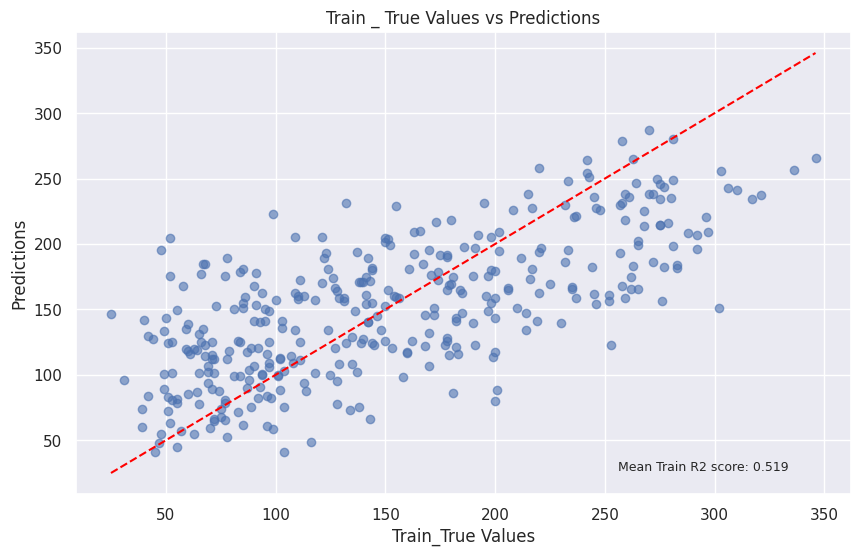

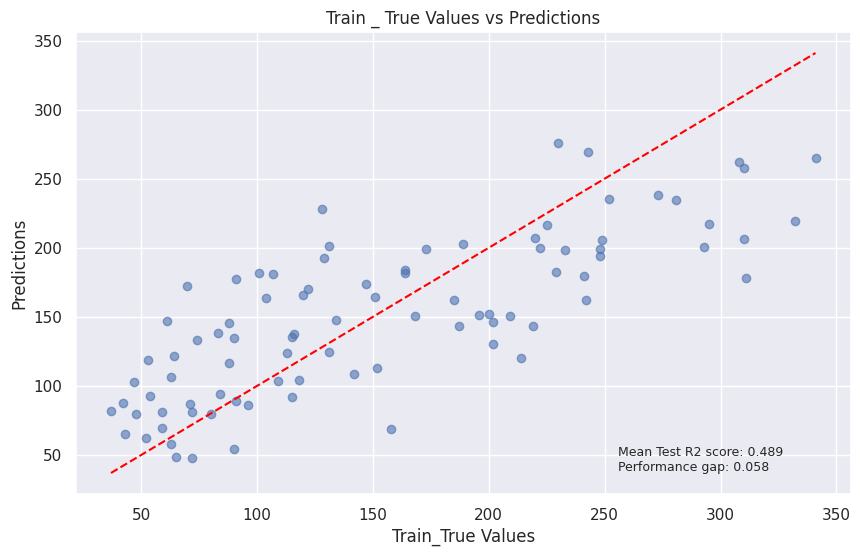


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Evaluating LinearRegression with K-Folds = 6
Mean Train R2 score: 0.519
Mean Test R2 score: 0.488
Performance gap: 0.060


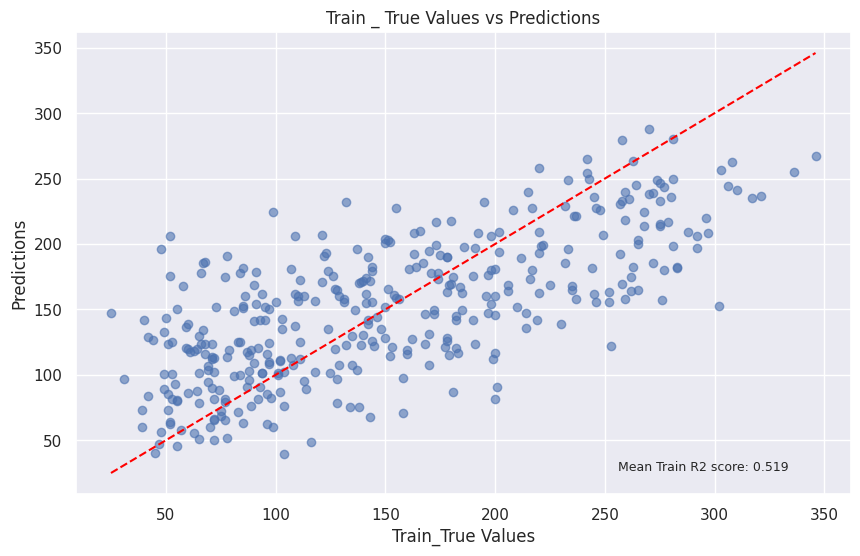

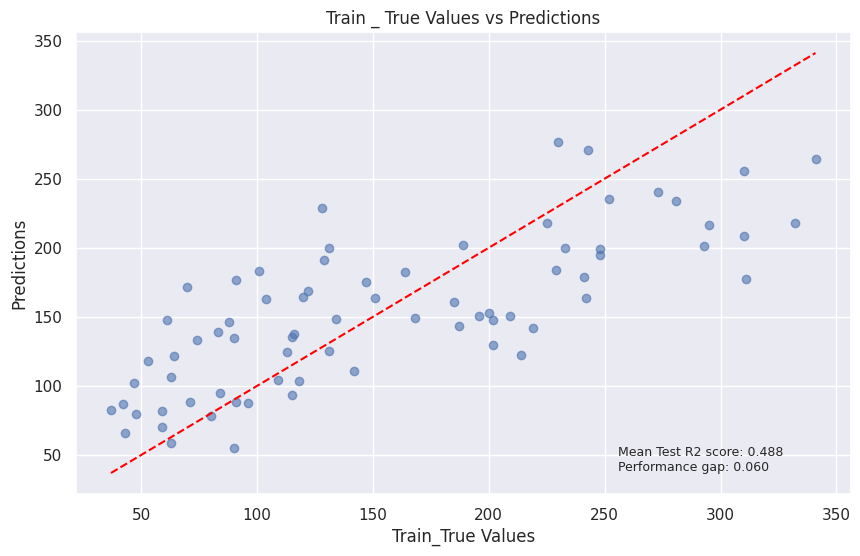


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Evaluating LinearRegression with K-Folds = 7
Mean Train R2 score: 0.519
Mean Test R2 score: 0.481
Performance gap: 0.075


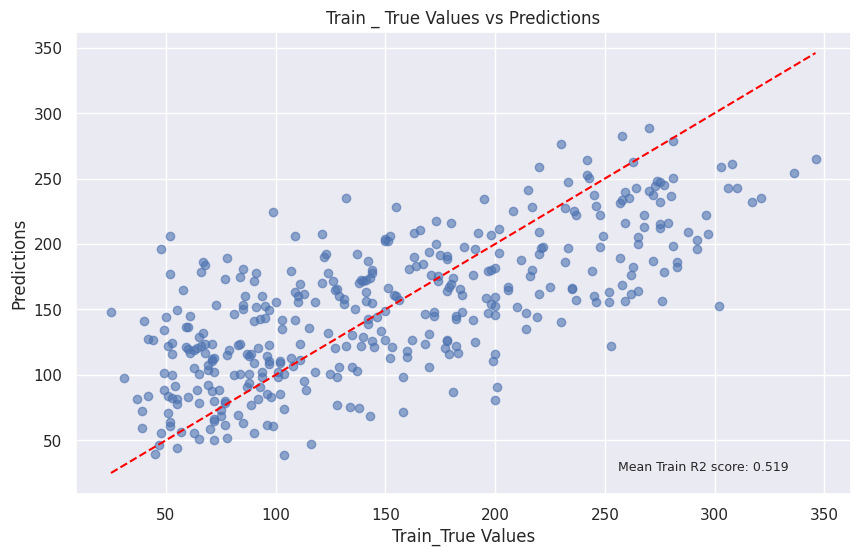

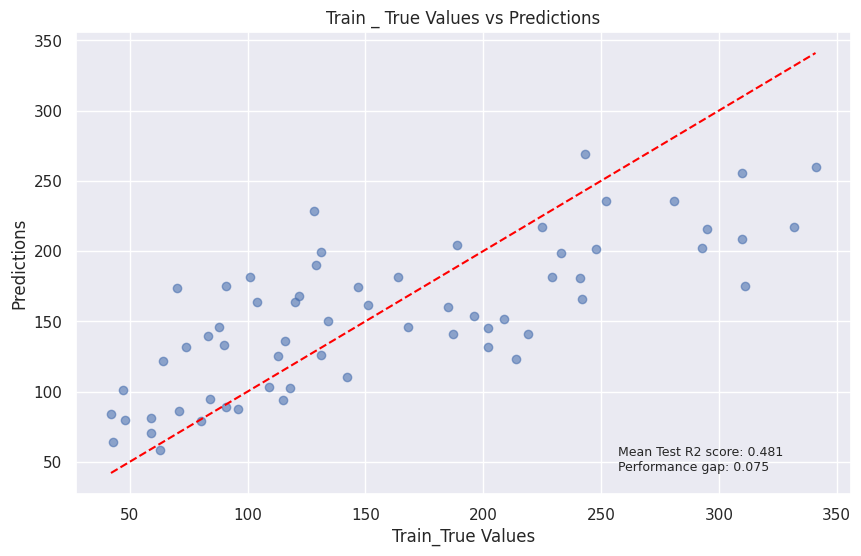


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Evaluating LinearRegression with K-Folds = 8
Mean Train R2 score: 0.519
Mean Test R2 score: 0.484
Performance gap: 0.067


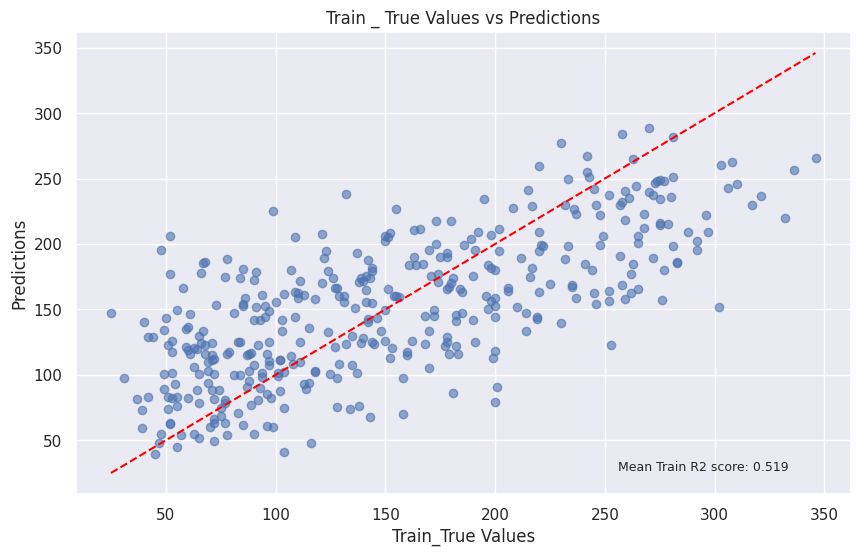

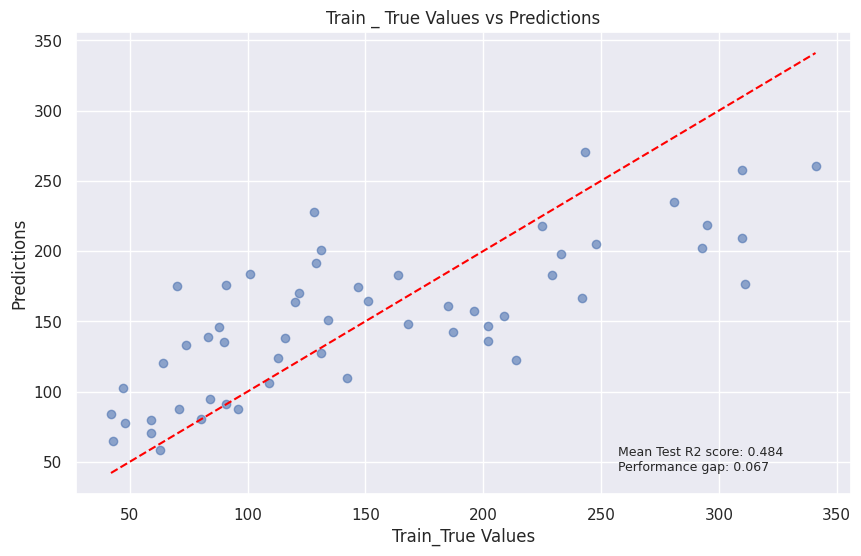


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Evaluating LinearRegression with K-Folds = 9
Mean Train R2 score: 0.519
Mean Test R2 score: 0.484
Performance gap: 0.067


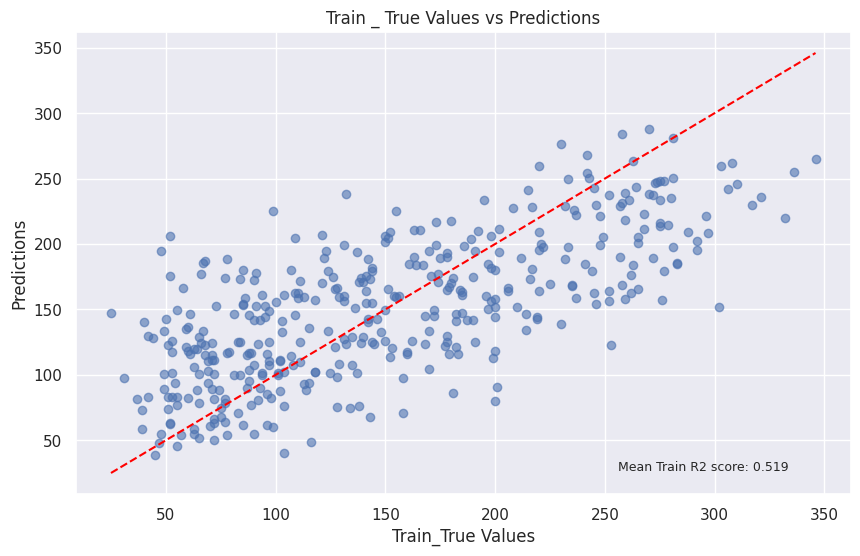

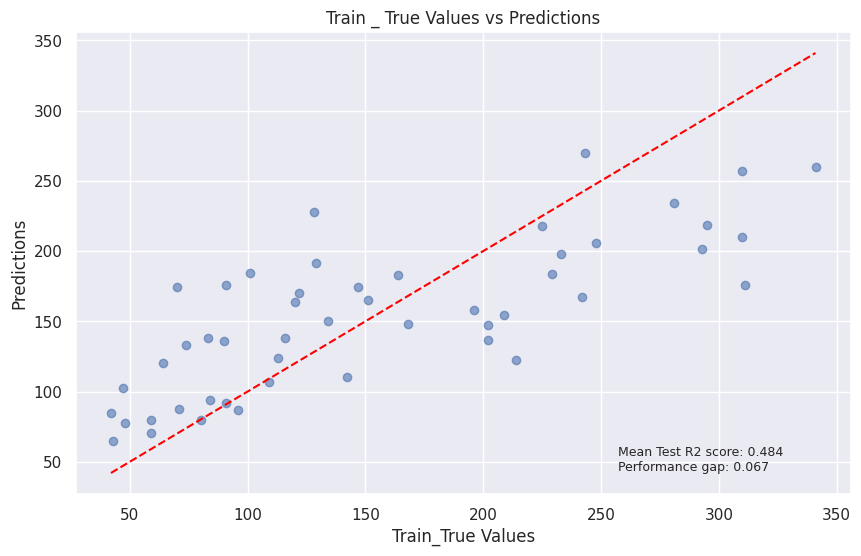


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Evaluating LinearRegression with K-Folds = 10
Mean Train R2 score: 0.519
Mean Test R2 score: 0.484
Performance gap: 0.067


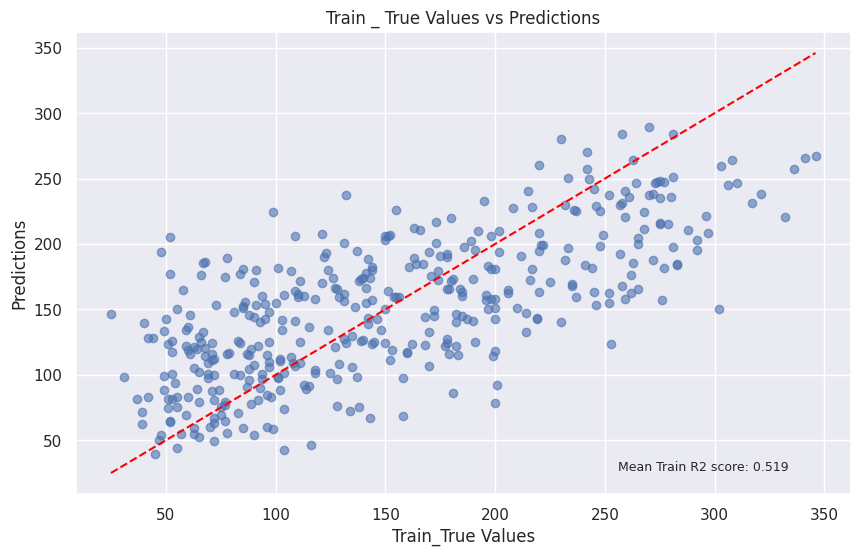

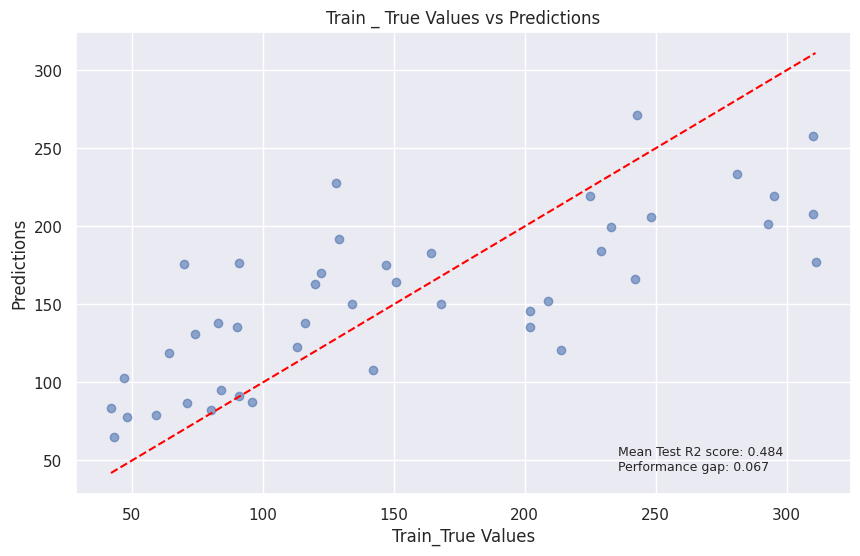


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
# Evaluation with KFold Cross-Validation
k_folds = [5, 6, 7, 8, 9, 10]

for k_f in k_folds:
    print(f"Evaluating LinearRegression with K-Folds = {k_f}")
    lr = LinearRegression()
    evaluate_model_with_visualization_cv(lr, (X, y), k=k_f, visualization = True)
    print(LINE_SEPARATOR)

####*Final Observations Data Pre-processing*

It can be seen that with cross validation the model performs better, which suggests that this partitioning of the dataset for subsequent surveys, in particular, with value of k = 5.

##*Model training with multiple linear regression*


Linear Regression (complete dataset)
Mean Train R2 score: 0.519
Mean Test R2 score: 0.489
Performance gap: 0.058


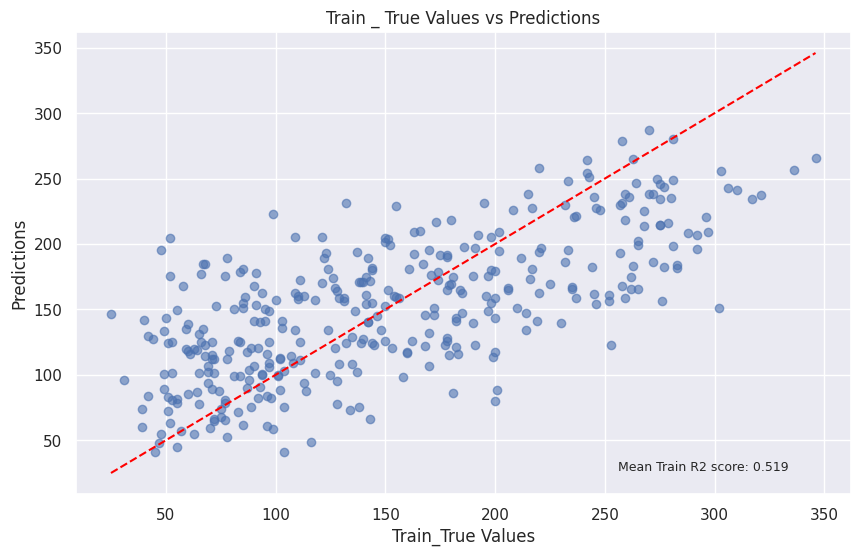

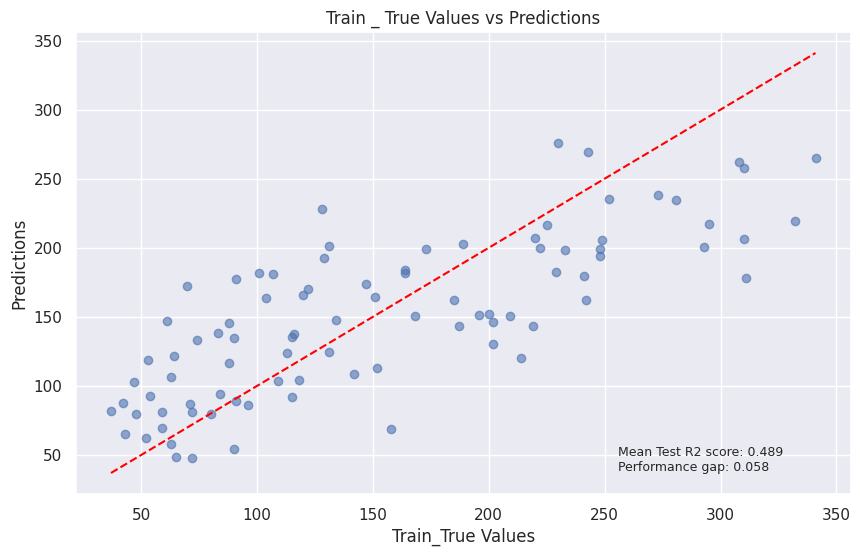

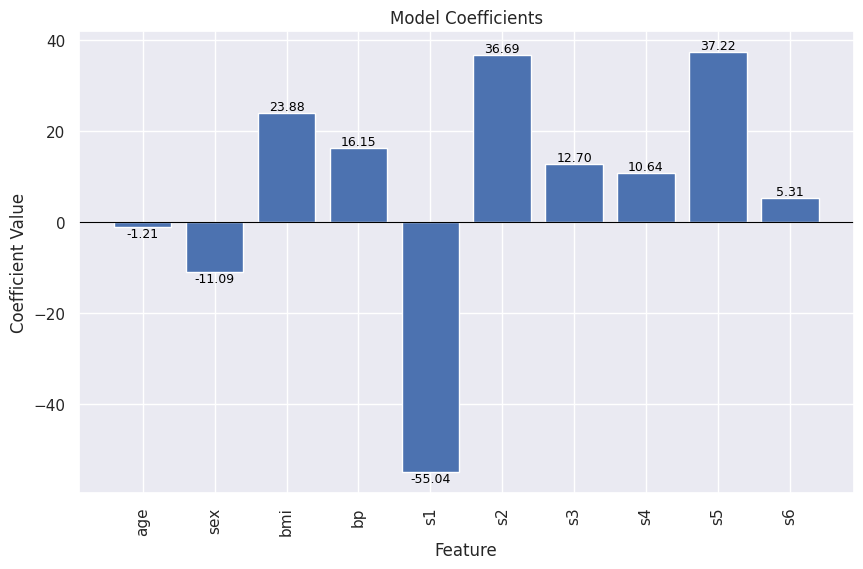


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Linear Regression (dataset no outliers)
Mean Train R2 score: 0.499
Mean Test R2 score: 0.445
Performance gap: 0.110

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Linear Regression (dataset no sex)
Mean Train R2 score: 0.502
Mean Test 

In [ ]:
# Initialize the Linear Regression model
lr = LinearRegression()
k_folds = 5

title_lr_dc = "Linear Regression (complete dataset)"
print(title_lr_dc)
mean_train_score_dc, mean_test_score_dc, gap_di_performance_dc = evaluate_model_with_visualization_cv(lr, (X, y), k = k_folds, visualization = True)
# Add the evaluation results to a dictionary for later analysis
add_to_evaluation_dict(title_lr_dc, mean_train_score_dc, mean_test_score_dc, gap_di_performance_dc, degree=None)
print("\n")
graphic_visualization_coefficients(lr, X, y)

print(LINE_SEPARATOR)
print(LINE_SEPARATOR)


title_no = "Linear Regression (dataset no outliers)"
print(title_no)
X_no_outliners = df_no_outliers.drop("target", axis=1)
y_no_outliners = df_no_outliers["target"]
evaluate_model_with_visualization_cv(lr, (X_no_outliners, y_no_outliners), k = k_folds)

print(LINE_SEPARATOR)
print(LINE_SEPARATOR)


title_ns = "Linear Regression (dataset no sex)"
print(title_ns)
X_no_sex = df.drop(columns= ["sex", "target"])
evaluate_model_with_visualization_cv(lr, (X_no_sex, y), k = k_folds)

print(LINE_SEPARATOR)
print(LINE_SEPARATOR)

title_na = "Linear Regression (dataset no age)"
print(title_na)
X_no_age = df.drop(columns= ["age", "target"])
evaluate_model_with_visualization_cv(lr, (X_no_sex, y), k = k_folds)

print(LINE_SEPARATOR)
print(LINE_SEPARATOR)

title_ns1 = "Linear Regression (dataset no s1)"
print(title_ns1)
X_no_s1 = df.drop(columns= ["s1", "target"])
evaluate_model_with_visualization_cv(lr, (X_no_sex, y), k = k_folds)

print(LINE_SEPARATOR)
print(LINE_SEPARATOR)

title_ns2 = "Linear Regression (dataset no s2)"
print(title_ns2)
X_no_s2 = df.drop(columns= ["s2", "target"])
evaluate_model_with_visualization_cv(lr, (X_no_sex, y), k = k_folds)

print(LINE_SEPARATOR)
print(LINE_SEPARATOR)

title_na3s = "Linear Regression (dataset no weak features: age, sex, s1, s2)"
print(title_na3s)
X_no_weak_all = df.drop(columns = ['age', 'sex', 's1', 's2', 'target'])
evaluate_model_with_visualization_cv(lr, (X_no_weak_all, y), k = k_folds)

print(LINE_SEPARATOR)
print(LINE_SEPARATOR)

###*Observations*


From the analyses, it can be seen that keeping multiple linear regression with outliners allows for a model that is better trained and more capable of making predictions with respect to the target. Which means that outliners still play an important role in training the model.

Considerations on the 'sex' feature : It can be seen that, although poorly correlated, the removal of the 'sex' feature results in a worsening of the model. Thus it turns out necessary to hold it.

Singular elimination of the features 'age', 's1', 's2' : removing one of these features tends to improve the performance of the model, so that feature turns out to be uninformative for the model.

Eliminating all weak variables tends to reduce model performance slightly, but improves the performance gap, suggesting that the model turns out to be somewhat less complex and more robust.

It is worthwhile to test the model by removing even just the 'age', 's1', 's2' features simultaneously.

##*Model training on reduced dataset (no features: age, s1, s2)*

Linear Regression (dataset no weak: age, s1, s2)
Mean Train R2 score: 0.512
Mean Test R2 score: 0.488
Performance gap: 0.046


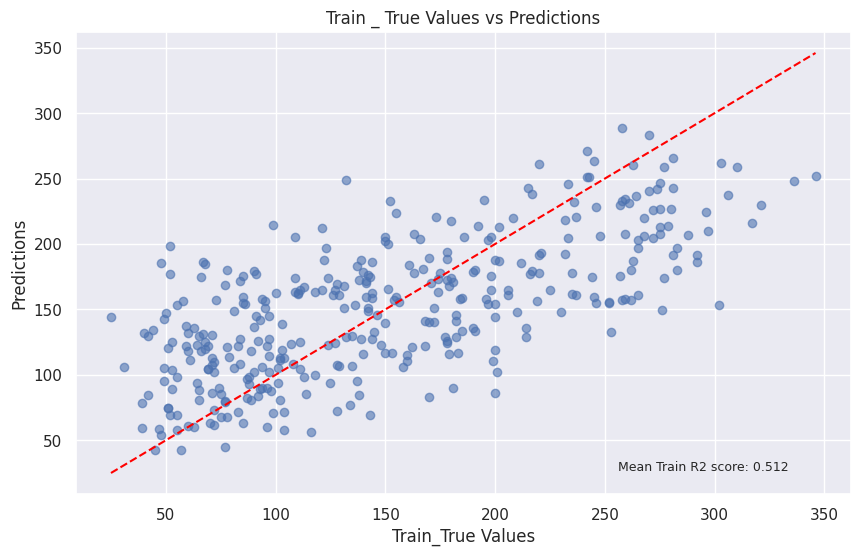

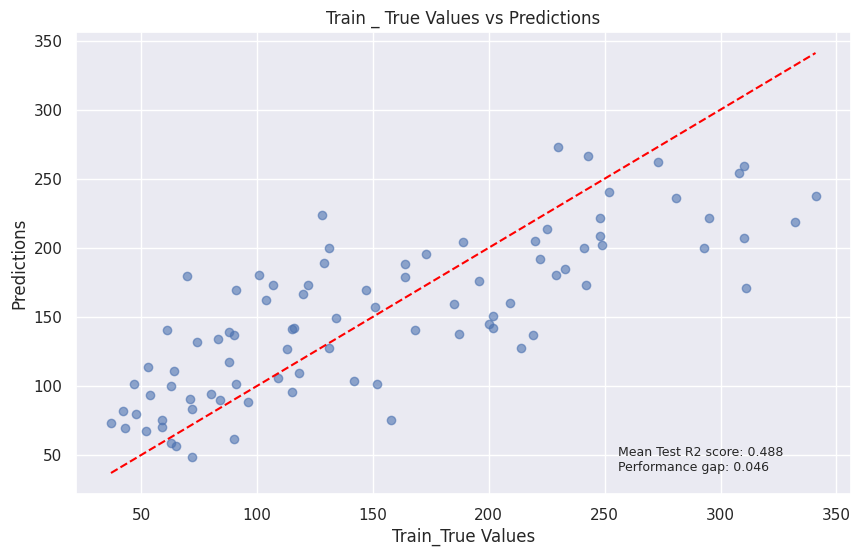

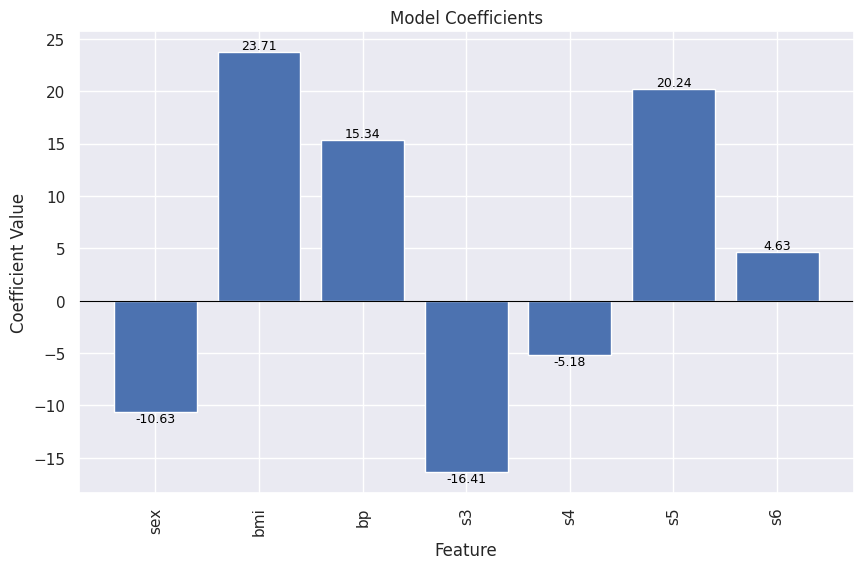

In [ ]:
title_pnw = "Linear Regression (dataset no weak: age, s1, s2)" #pnw = partial no weak
print(title_pnw)
X_pnw = df.drop(columns = ['age', 's1', 's2', 'target'])
mean_train_score_pnw, mean_test_score_pnw, gap_di_performance_pnw = evaluate_model_with_visualization_cv(lr, (X_pnw, y), k = k_folds, visualization = True)
add_to_evaluation_dict(title_pnw, mean_train_score_pnw, mean_test_score_pnw, gap_di_performance_pnw, degree = None)
print("\n")
graphic_visualization_coefficients(lr, X_pnw, y)

###*Observations*

The model, considering the reduced database without the weak features ('age', 's1', 's2'), has R2 score values very similar to those of the model tested on the full dataset, but a smaller performance gap (0.046 vs. 0.058).
This suggests that the reduced model has better generalization, with a smaller difference between performance on the train set and test set, thus also reducing overfitting.

Currently, the model considering the reduced dataset, with the outliners but without the features 'age', 's1', 's2', is preferred.

Adding the results of the model tested on the full dataset and the model tested on the reduced dataset to the 'evaluation_dict' dictionary with 'add_to_evaluation_dict()' will allow them to be compared with the results of the polynomial regression, which is worth testing to confirm the assumptions made so far.

After that, it will be continued by trying to improve the chosen model through the use of regularizations.

##*Model training with polynomial regression*

Polynomial Regression
Degree = 2
Mean Train R2 score: 0.606
Mean Test R2 score: 0.412
Performance gap: 0.320


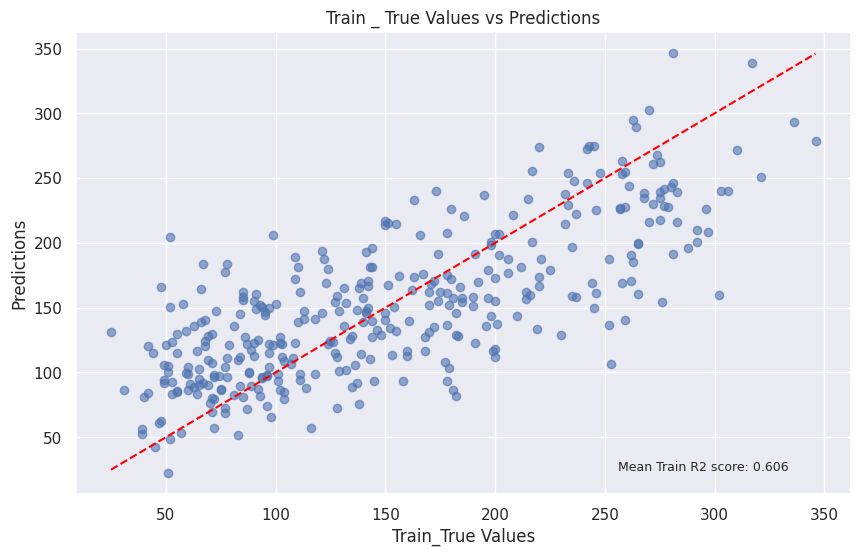

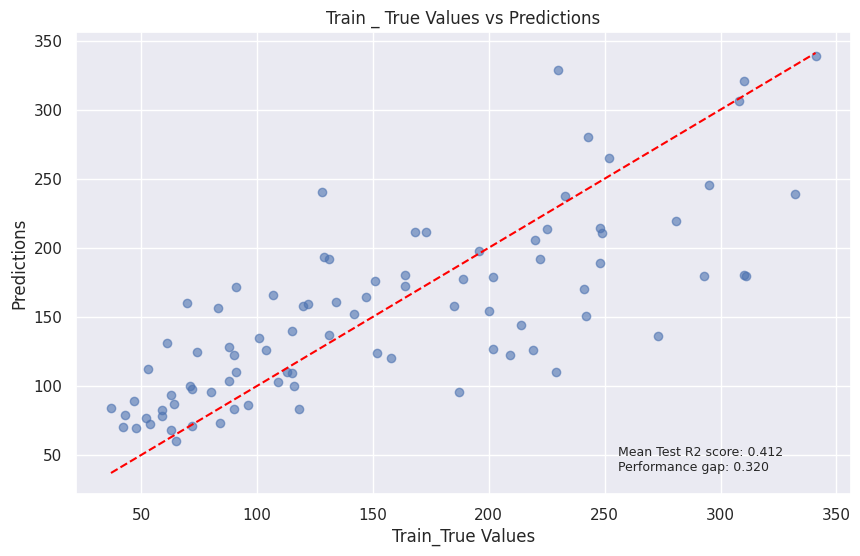


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Degree = 3
Mean Train R2 score: 0.880
Mean Test R2 score: -96.245
Performance gap: 110.331


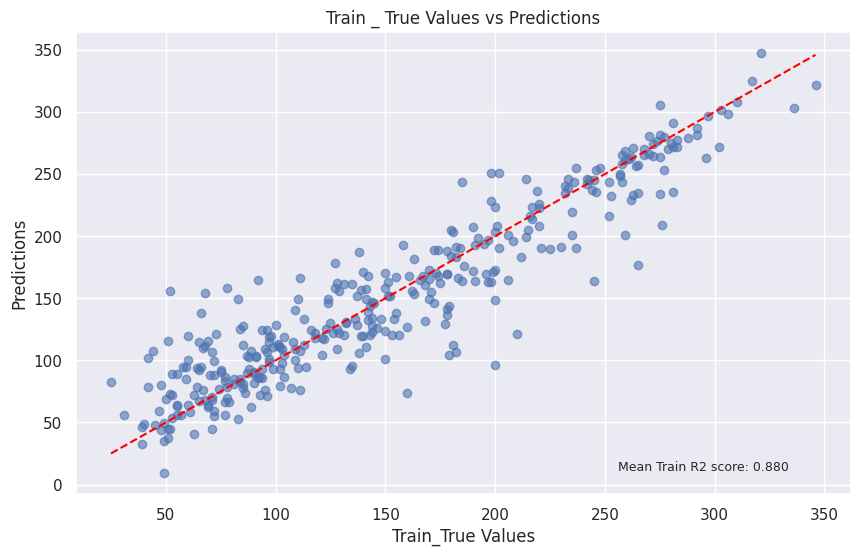

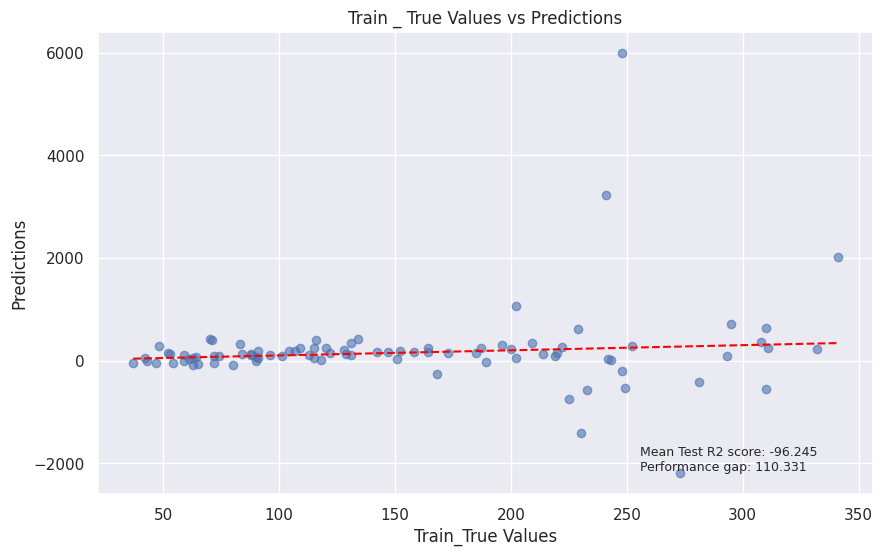


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Regressione polinomiale (+ bias)
Degree = 2
Mean Train R2 score: 0.606
Mean Test R2 score: 0.412
Performance gap: 0.320

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Degree = 3
Mean Train R2 score: -0.141
Mean Test R2 score: -109.051


In [ ]:
title_pr = "Polynomial Regression" #pr = Polynomial Regression
print(title_pr)
degree =[2, 3]

for d in degree:
    print(f"Degree = {d}")
    mean_train_score_pr, mean_test_score_pr, gap_di_performance_pr = evaluate_polynomial_model((X, y), degree = d, bias = False, visualization = True)
    add_to_evaluation_dict(title_pr, mean_train_score_pr, mean_test_score_pr, gap_di_performance_pr, degree = d)
    print(LINE_SEPARATOR)
    print(LINE_SEPARATOR)


# Title for the Polynomial Regression evaluation with bias
title_pr_bias = "Regressione polinomiale (+ bias)"
print(title_pr_bias)
for d in degree:
    print(f"Degree = {d}")
    evaluate_polynomial_model((X, y), degree = d, bias = True)
    print(LINE_SEPARATOR)
    print(LINE_SEPARATOR)

###*Observations*

It can be seen that polynomial regression, especially when of degree greater than two, leads to strong overfitting problems, creating a model that is very strong on the train data but not at all performing well on the test data.

Furthermore, the presence or absence of bias does not significantly affect training, but this is also due to the scaling that centers the data around the origin anyway.

By adding the obtained values of the polynomial regression to the 'evaluation_dict' dictionary, it is possible to compare them directly with the results obtained from the multiple linear regression.

##*Final Observations (Pre-processing and Model Training)*

In [ ]:
# Format the values in the dictionary
format_dict(evaluation_dict)

# Convert the dictionary to a formatted JSON string
json_str = json.dumps(evaluation_dict, indent=4)

# Print the formatted JSON string
print(json_str)

{
    "Linear Regression (complete dataset)": {
        "Train": "0.519",
        "Test": "0.489",
        "Gap di performance": "0.058"
    },
    "Linear Regression (dataset no weak: age, s1, s2)": {
        "Train": "0.512",
        "Test": "0.488",
        "Gap di performance": "0.046"
    },
    "Polynomial Regression degree 2": {
        "Train": "0.606",
        "Test": "0.412",
        "Gap di performance": "0.320"
    },
    "Polynomial Regression degree 3": {
        "Train": "0.880",
        "Test": "-96.245",
        "Gap di performance": "110.331"
    }
}


Polynomial regression shows strong signs of overfitting in both grades, despite the use of cross_validation.

However, the most balanced solution between train set and test set turns out to be multiple linear regression as hypothesized at the beginning.

It is possible to try to improve the performance of the model by using regularizations, so that a final comparison can be made between the model teste on reduced dataset and the one tested on the full dataset.

It is worth trying both Ridge for multicollinearity and the presence of outliners, and Lasso for the presence of features that appear to be uncorrelated with the target.

It is also useful to try combining the two regularizations with ElasticNet

#**Regularizations**

##*Set alpha values*

In [ ]:
# Set of alpha values
alpha_values = [0.0001, 0.001, 0.1, 1, 10, 20, 30, 40]

##*Ridge Regression*

Ridge (complete dataset)

Alpha: 0.0001
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.001
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.1
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 1
Mean R2 train: 0.519
Mean R2 test: 0.490
Performance gap: 0.057


Alpha: 10
Mean R2 train: 0.517
Mean R2 test: 0.489
Performance gap: 0.053


Alpha: 20
Mean R2 train: 0.516
Mean R2 test: 0.489
Performance gap: 0.051


Alpha: 30
Mean R2 train: 0.515
Mean R2 test: 0.489
Performance gap: 0.050


Alpha: 40
Mean R2 train: 0.513
Mean R2 test: 0.489
Performance gap: 0.048


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Best model: Ridge(alpha=30)
Best model R2 test score: 0.489
Best gap di performance: 0.050

-----------------------------------------------------------------

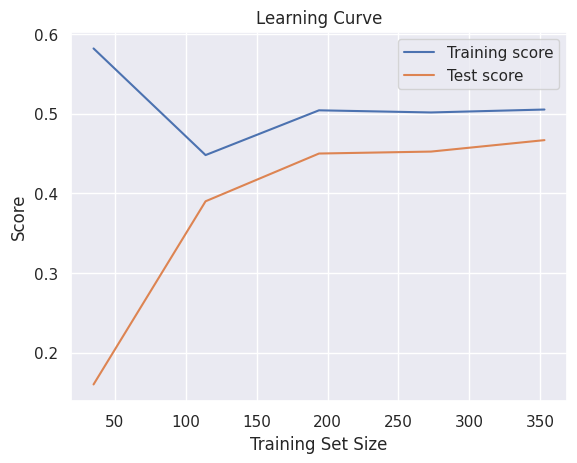

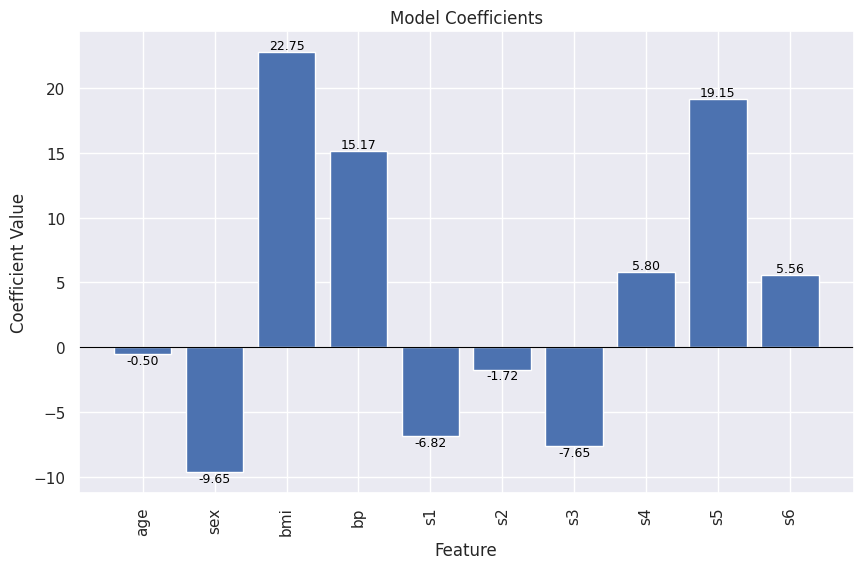


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ridge (dataset no weak: age, s1, s2)

Alpha: 0.0001
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.001
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.1
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 1
Mean R2 train: 0.512
Mean R2 test: 0.489
Performance gap: 0.046


Alpha: 10
Mean R2 train: 0.512
Mean R2 test: 0.489
Performance gap: 0.044


Alpha: 20
Mean R2 train: 0.511
Mean R2 test: 0.489
Performance gap: 0.042


Alpha: 30
Mean R2 train: 0.510
Mean R2 test: 0.489
Performance gap: 0.041


Alpha: 40
Mean R2 train: 0.508
Mean R2 test: 0.488
Performance gap: 0.040


------------------------------------------------------------------------------------------------------------------------------------------------

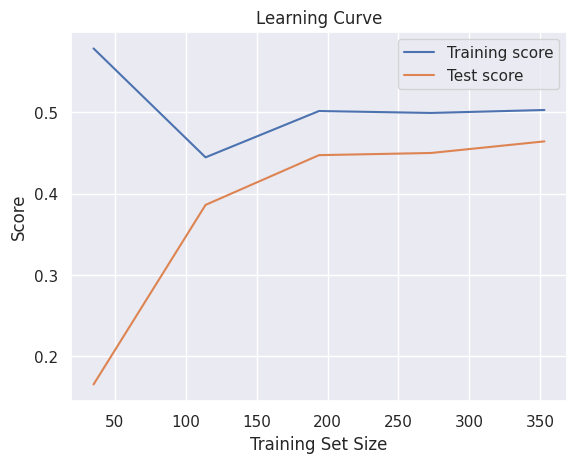

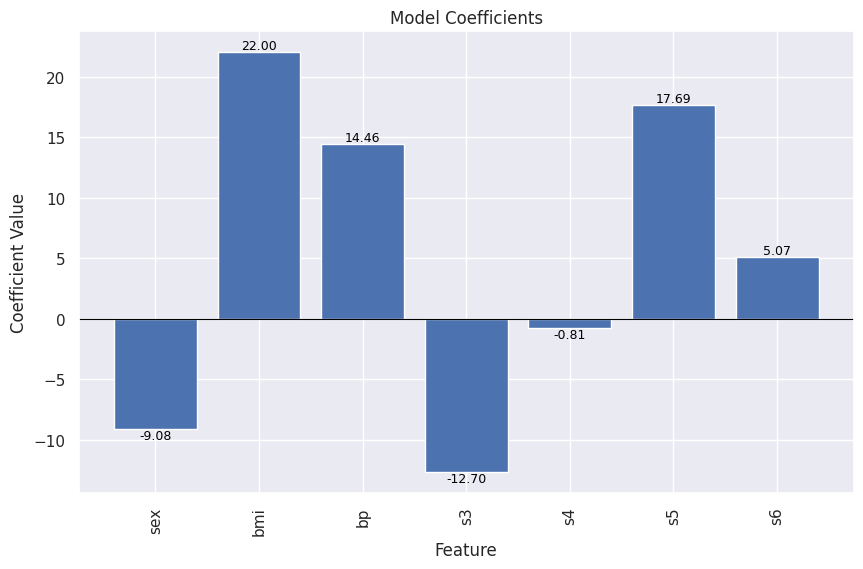


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
# Model evaluation of Ridge with CV on the complete dataset
print("Ridge (complete dataset)")
best_model, best_r2_train, best_r2_test, best_gap_di_performance = evaluate_regularized_model_cv(Ridge,
                                                                                                             (X, y),
                                                                                                             alpha_values,
                                                                                                             best_r2_train_non_reg = mean_train_score_dc,
                                                                                                             best_r2_test_non_reg= mean_test_score_dc,
                                                                                                             tolerance=0.005)
print(LINE_SEPARATOR)
print(f"Best model: {best_model}")
print(f"Best model R2 test score: {best_r2_test:.3f}")
print(f"Best gap di performance: {best_gap_di_performance:.3f}")

print(LINE_SEPARATOR)

print_learning_curve(best_model, X, y)
print("\n")
graphic_visualization_coefficients(best_model, X, y)

print(LINE_SEPARATOR)

# Model evaluation of Ridge with CV on the reduced dataset (no features: age, s1, s2)
print("Ridge (dataset no weak: age, s1, s2)")
best_model, best_r2_train, best_r2_test, best_gap_di_performance = evaluate_regularized_model_cv(Ridge,
                                                                                                             (X_pnw, y),
                                                                                                             alpha_values,
                                                                                                             best_r2_train_non_reg = mean_train_score_pnw,
                                                                                                             best_r2_test_non_reg= mean_test_score_pnw,
                                                                                                             tolerance=0.005)
print(LINE_SEPARATOR)
print(f"Best model: {best_model:}")
print(f"Best model R2 test score: {best_r2_test:.3f}")
print(f"Best gap di performance: {best_gap_di_performance:.3f}")

print(LINE_SEPARATOR)

print_learning_curve(best_model, X, y)
print("\n")
graphic_visualization_coefficients(best_model, X_pnw, y)

print(LINE_SEPARATOR)

###*Observations*

It is evident from the 'application of Ridge regularization on the full dataset and the reduced one an improvement in the overall performance of the model.
This is due to the presence of collinearity phenomena (see correlation matrix, e.g.: feature 's4' presenting a value greater than 0.5 - thus a strong correlation - with 's1', 's2', 's3', 's5' or correlation between 's1' and 's5') and the presence, possibly, of overfitting, despite the low 'performance_gap' values of the original models.

##*Lasso Regression*

Lasso (complete dataset)

Alpha: 0.0001
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.001
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.1
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.057


Alpha: 1
Mean R2 train: 0.515
Mean R2 test: 0.490
Performance gap: 0.048


Alpha: 10
Mean R2 train: 0.459
Mean R2 test: 0.443
Performance gap: 0.034


Alpha: 20
Mean R2 train: 0.370
Mean R2 test: 0.357
Performance gap: 0.037


Alpha: 30
Mean R2 train: 0.250
Mean R2 test: 0.240
Performance gap: 0.037


Alpha: 40
Mean R2 train: 0.089
Mean R2 test: 0.083
Performance gap: 0.072

Best model: Lasso(alpha=1)
Best model R2 test score: 0.490
Best performance gap: 0.048

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



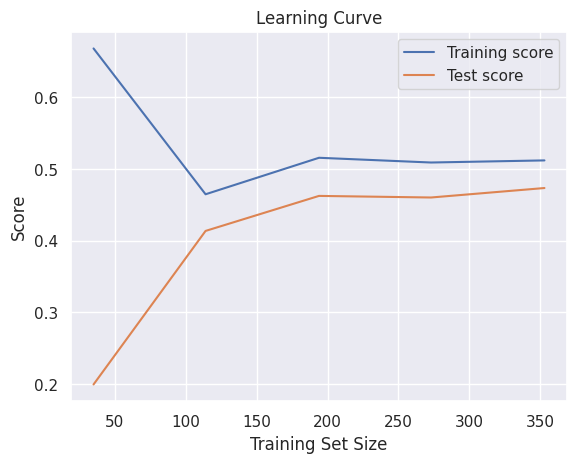

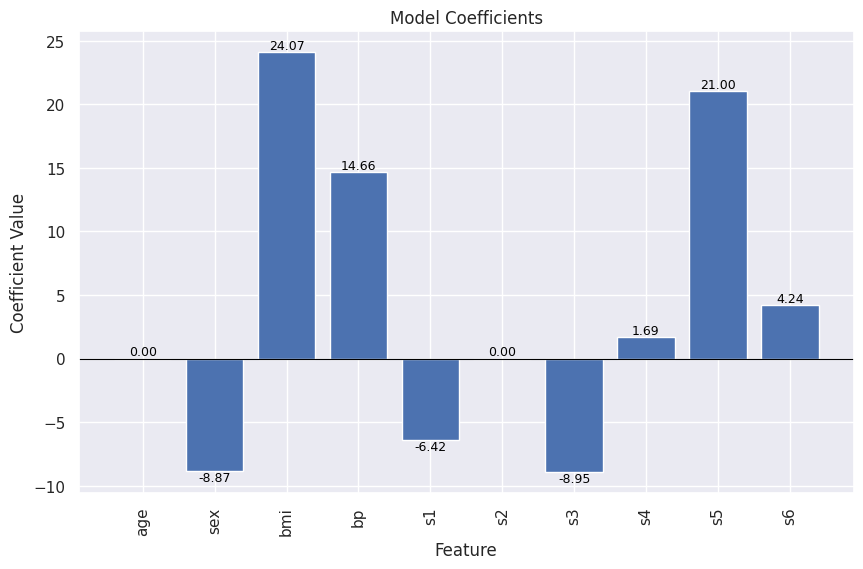


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Lasso (dataset no weak: age, s1, s2)

Alpha: 0.0001
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.001
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.1
Mean R2 train: 0.512
Mean R2 test: 0.489
Performance gap: 0.046


Alpha: 1
Mean R2 train: 0.510
Mean R2 test: 0.489
Performance gap: 0.041


Alpha: 10
Mean R2 train: 0.459
Mean R2 test: 0.443
Performance gap: 0.034


Alpha: 20
Mean R2 train: 0.370
Mean R2 test: 0.357
Performance gap: 0.037


Alpha: 30
Mean R2 train: 0.250
Mean R2 test: 0.240
Performance gap: 0.037


Alpha: 40
Mean R2 train: 0.089
Mean R2 test: 0.083
Performance gap: 0.072

Best model: Lasso(alpha=1)
Best model R2 test score: 0.489
Best performance gap: 0.041

---------------------------------------------------------

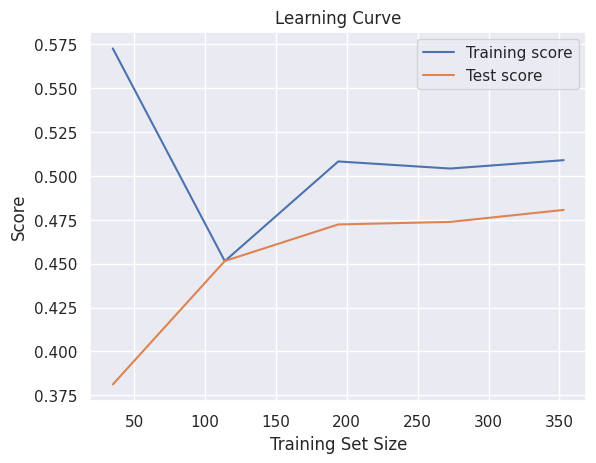

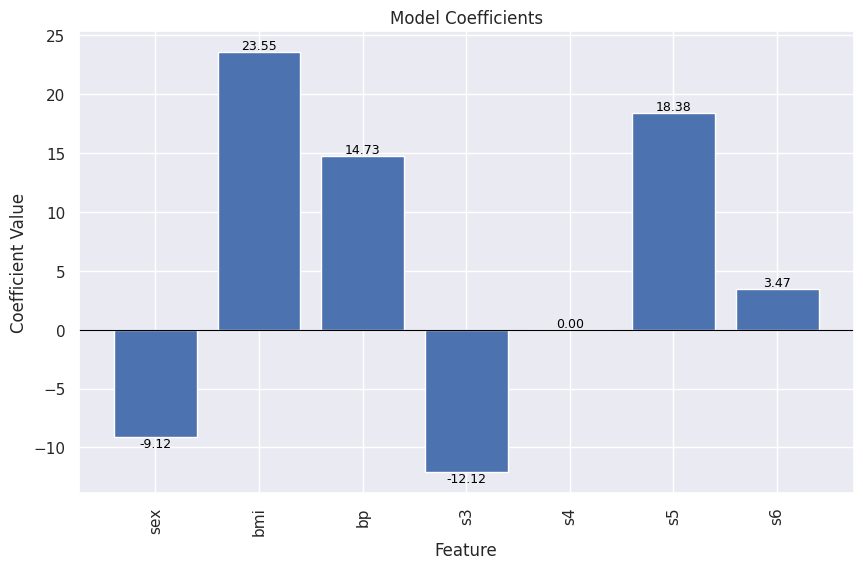


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
# Evaluation of Lasso model with CV on complete dataset
title_l_dc = "Lasso (complete dataset)"  # l_dc = lasso - complete dataset
print(title_l_dc)
best_model_l_dc, best_r2_train_l_dc, best_r2_test_l_dc, best_performance_gap_l_dc = evaluate_regularized_model_cv(Lasso,
                                                                                                                  (X, y),
                                                                                                                  alpha_values,
                                                                                                                  best_r2_train_non_reg=mean_train_score_dc,
                                                                                                                  best_r2_test_non_reg=mean_test_score_dc,
                                                                                                                  tolerance=0.005)

print(f"Best model: {best_model_l_dc}")
print(f"Best model R2 test score: {best_r2_test_l_dc:.3f}")
print(f"Best performance gap: {best_performance_gap_l_dc:.3f}")
add_to_evaluation_dict(title_l_dc, best_r2_train_l_dc, best_r2_test_l_dc, best_performance_gap_l_dc, degree=None)

print(LINE_SEPARATOR)

print_learning_curve(best_model_l_dc, X, y)
print("\n")
graphic_visualization_coefficients(best_model_l_dc, X, y)

print(LINE_SEPARATOR)

# Evaluation of Lasso model with CV on reduced dataset
print("Lasso (dataset no weak: age, s1, s2)")
best_model_l_pnw, best_r2_train_l_pnw, best_r2_test_l_pnw, best_performance_gap_l_pnw = evaluate_regularized_model_cv(Lasso,
                                                                                                                      (X_pnw, y),
                                                                                                                      alpha_values,
                                                                                                                      best_r2_train_non_reg=mean_train_score_pnw,
                                                                                                                      best_r2_test_non_reg=mean_test_score_pnw,
                                                                                                                      tolerance=0.005)

print(f"Best model: {best_model_l_pnw}")
print(f"Best model R2 test score: {best_r2_test_l_pnw:.3f}")
print(f"Best performance gap: {best_performance_gap_l_pnw:.3f}")

print(LINE_SEPARATOR)

print_learning_curve(best_model_l_pnw, X_pnw, y)
print("\n")
graphic_visualization_coefficients(best_model_l_pnw, X_pnw, y)

print(LINE_SEPARATOR)

###*Observations*

Lasso regularization on the full database confirms that the features 'age' and 's2' are not significant for training the model, while 's1' retains some significance.

In the reduced database (where the features 'age', 's1' and 's2' are not present), however, it can be seen that the feature 's4' is also less significant for this the model.

##*ElasticNet Regression*

ElasticNet (complete database)

Alpha: 0.0001, L1 Ratio: 0.1
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.0001, L1 Ratio: 0.5
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.0001, L1 Ratio: 0.9
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.0001, L1 Ratio: 1
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.001, L1 Ratio: 0.1
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.001, L1 Ratio: 0.5
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.001, L1 Ratio: 0.9
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.001, L1 Ratio: 1
Mean R2 train: 0.519
Mean R2 test: 0.489
Performance gap: 0.058


Alpha: 0.1, L1 Ratio: 0.1
Mean R2 train: 0.514
Mean R2 test: 0.489
Performance gap: 0.049


Alpha: 0.1, L1 Ratio: 0.5
Mean R2 train: 0.516
Mean R2 test: 0.489
Performance gap: 0.051


Alpha: 0.1, L1 Ratio: 0.9
Mean R

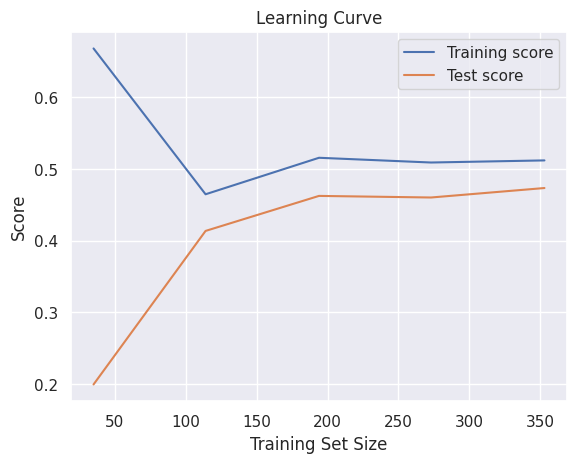

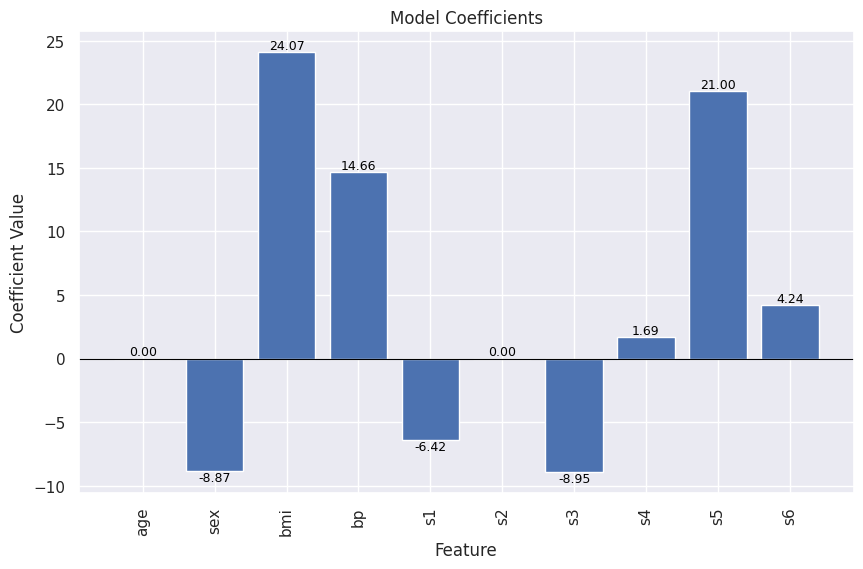


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ElasticNet (dataset no weak: age, s1, s2)

Alpha: 0.0001, L1 Ratio: 0.1
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.0001, L1 Ratio: 0.5
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.0001, L1 Ratio: 0.9
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.0001, L1 Ratio: 1
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.001, L1 Ratio: 0.1
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.001, L1 Ratio: 0.5
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.001, L1 Ratio: 0.9
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Alpha: 0.001, L1 Ratio: 1
Mean R2 train: 0.512
Mean R2 test: 0.488
Performance gap: 0.046


Al

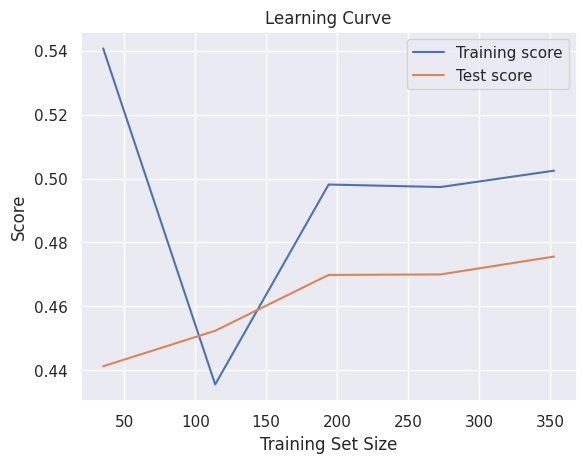

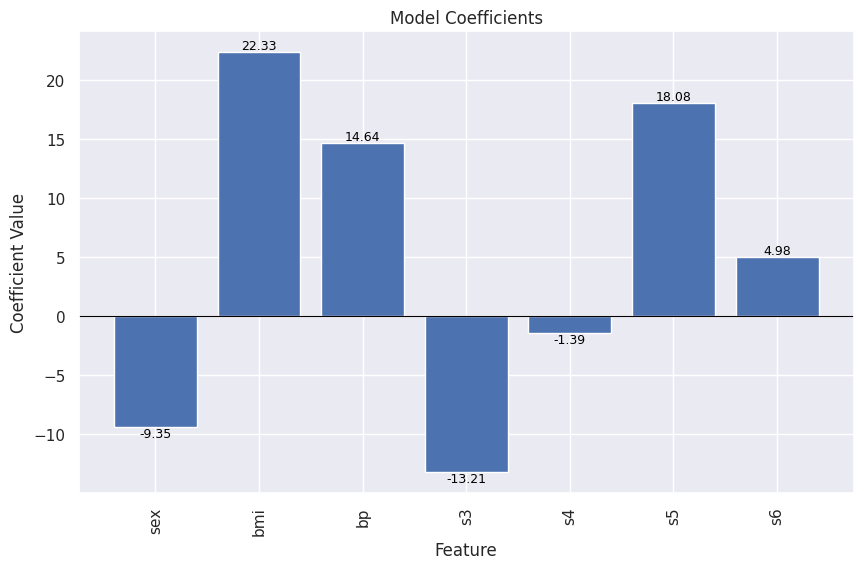

In [ ]:
l1_ratio_values = [0.1, 0.5, 0.9, 1]

# Suppose we want to evaluate an ElasticNet model
print("ElasticNet (complete database)")
best_elastic_net_model, best_r2_train_en, best_r2_test_en, best_performance_gap_en = evaluate_elastic_net_model((X, y),
                                                                                                                    alpha_values,
                                                                                                                    l1_ratio_values,
                                                                                                                    best_r2_train_non_reg = mean_train_score_dc,
                                                                                                                    best_r2_test_non_reg= mean_test_score_dc,
                                                                                                                    tolerance=0.005)

print(f"Best ElasticNet model: {best_elastic_net_model}")
print(f"Best model R2 test score: {best_r2_test_en:.3f}")
print(f"Best performance gap: {best_performance_gap_en:.3f}")

print_learning_curve(best_elastic_net_model, X, y)
print("\n")
graphic_visualization_coefficients(best_elastic_net_model, X, y)

print(LINE_SEPARATOR)

# Suppose we want to evaluate an ElasticNet model
title_enw = "ElasticNet (dataset no weak: age, s1, s2)"
print(title_enw)
best_model_enw, best_r2_train_enw, best_en_r2_test_enw, best_performance_gap_enw = evaluate_elastic_net_model((X_pnw, y),
                                                                                                                  alpha_values,
                                                                                                                  l1_ratio_values,
                                                                                                                  best_r2_train_non_reg = mean_train_score_pnw,
                                                                                                                  best_r2_test_non_reg= mean_test_score_pnw,
                                                                                                                  tolerance=0.005)

print(f"Best ElasticNet model: {best_model_enw}")
print(f"Best model R2 test score: {best_en_r2_test_enw:.3f}")
print(f"Best performance gap: {best_gap_di_performance:.3f}")
add_to_evaluation_dict(title_enw, best_r2_train_enw, best_en_r2_test_enw, best_performance_gap_enw, degree=None)

print_learning_curve(best_model_enw, X_pnw, y)
print("\n")
graphic_visualization_coefficients(best_model_enw, X_pnw, y)

##*Final Observations (Regularizations)*

For the model on the full dataset, the best values, 'R2' and 'performance gap,' obtained by testing the model with ElasticNet regression, occur when l1_ratio=1, that is, when L1 - Lasso regularization is used. Therefore, it is convenient to use L1 regularization. The result is consistent, considering that the features 'age', 's1', 's2' have not yet been dropped. It can be seen from the graph of model coefficients that 's1' affects the model quite significantly, so dropping it can be considered incorrect.

For the model on the reduced dataset, we note that the best values of 'R2' and 'performance gap' are obtained using the ElasticNet regularization with value of l1_ratio = 0.1, indicating a higher incidence of Ridge regression. Thus, it tends to reduce the phenomenon of multicollinearity, because feature selection has been applied previously.

Finally, by adding the values of the two best regressions on the full and reduced dataset, a comparison of the best performance to date can be made.

#**Final evaluations and model selection**

##*Model selection*

In [ ]:
# Format the values of the dictionary
format_dict(evaluation_dict)

# Convert to formatted JSON string and print
json_str1 = json.dumps(evaluation_dict, indent=4)

# Remove unwanted sections from the dictionary
if "Polynomial Regression degree 2" in evaluation_dict:
    del evaluation_dict["Polynomial Regression degree 2"]
if "Polynomial Regression degree 3" in evaluation_dict:
    del evaluation_dict["Polynomial Regression degree 3"]

# Print the updated dictionary
json_str_cleaned = json.dumps(evaluation_dict, indent=4)
print(json_str_cleaned)

{
    "Linear Regression (complete dataset)": {
        "Train": "0.519",
        "Test": "0.489",
        "Gap di performance": "0.058"
    },
    "Linear Regression (dataset no weak: age, s1, s2)": {
        "Train": "0.512",
        "Test": "0.488",
        "Gap di performance": "0.046"
    },
    "Lasso (complete dataset)": {
        "Train": "0.515",
        "Test": "0.490",
        "Gap di performance": "0.048"
    },
    "ElasticNet (dataset no weak: age, s1, s2)": {
        "Train": "0.509",
        "Test": "0.489",
        "Gap di performance": "0.040"
    }
}


##*Conclusions*

The ElasticNet model (dataset no weak: age, s1, s2) seems to be the best choice based on the data provided. Although it has the lowest training score, it has a competitive test score and the lowest performance gap, which suggests that it generalizes better on the unseen data. The reduction in the performance gap is often a sign that the model is balancing the fitting to the training data and the performance on the test data well, which is a good indicator of a robust and reliable model.

Regarding the significance of the features, considering that 's4' (total cholesterol / HDL), 's3' (HDL), 's2' (LDL), and 's1' (total serum cholesterol) are somehow related measures (they all concern cholesterol), these tend to complicate the training of the model.

In effect, despite the influence of 's1', observable in the Ridge, Lasso, and ElasticNet graphs on the complete model, when the models are tested on the reduced dataset, the R² values on the test data do not significantly decrease (-0.001). On the contrary, the performance gap decreases, indicating a better handling of overfitting.